In [1]:
import os
import PyPDF2
import pandas as pd
import networkx as nx
from collections import defaultdict
from pathlib import Path
import spacy
import nltk
#from transformers import pipeline
import tensorflow as tf
from transformers import pipeline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
import tensorflow as tf
print(tf.__version__)

# or for PyTorch
import torch
print(torch.__version__)


2.18.0
2.5.1


In [3]:
# named entity recognition (NER) and relationship extraction

In [39]:
class PDFTextAnalyzer:
    def __init__(self):
        # Load English language model
        self.nlp = spacy.load("en_core_web_sm")

        # Initialize the summarization pipeline
        #self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn")  

        # Entity types to track
        self.important_entities = {
            'ORG', 'PERSON', 'GPE', #'MONEY'#, 'DATE'
        }
        
        # Storage for extracted information
        self.entities = defaultdict(set)
        self.relationships = []
        self.document_metadata = []
    
    def read_pdf(self, pdf_path):
        """Extract text from a single PDF file"""
        try:
            with open(pdf_path, 'rb') as file:
                # Create PDF reader object
                pdf_reader = PyPDF2.PdfReader(file)
                
                # Extract text from all pages
                text = ""
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"
                
                return text.strip()
        except Exception as e:
            print(f"Error reading PDF {pdf_path}: {str(e)}")
            return ""

    def summarize_text(self, text):
        """Summarize the given text using a summarization model"""
        try:
            # Use the summarizer pipeline to summarize the text
            summary = self.summarizer(text, max_length=300, min_length=50, do_sample=False)
            return summary[0]['summary_text']
        except Exception as e:
            print(f"Error summarizing text: {str(e)}")
            return text

    def process_directory(self, directory_path):
        """Process all PDFs in a directory"""
        dir_path = Path(directory_path)
        
        # Process each PDF file
        for pdf_path in dir_path.glob("*.pdf"):
            try:
                # Read PDF content
                text = self.read_pdf(pdf_path)
                if text:
                    # Process the text
                    self.extract_entities_and_relationships(text, source=pdf_path.name)
                    print(f"Successfully processed: {pdf_path.name}")
            except Exception as e:
                print(f"Error processing {pdf_path.name}: {str(e)}")
    
    def extract_entities_and_relationships(self, text, source=None):
        """Extract entities and their relationships from summarized text"""

        ##summarized_text = self.summarize_text(text)  # Summarize before processing
        
        ## TOKENIZATION 
        doc = self.nlp(text)
        
        # Extract entities
        doc_entities = []
        for ent in doc.ents:
            if ent.label_ in self.important_entities:
                self.entities[ent.label_].add((ent.text, source))
                doc_entities.append((ent.text, ent.label_))
        
        # Extract relationships from each sentence
        for sent in doc.sents:
            sent_doc = self.nlp(sent.text)
            entities_in_sent = [(e.text, e.label_) for e in sent_doc.ents 
                              if e.label_ in self.important_entities]
            
            if len(entities_in_sent) >= 2:
                for i in range(len(entities_in_sent)-1):
                    self.relationships.append({
                        'source': entities_in_sent[i][0],
                        'target': entities_in_sent[i + 1][0],
                        'sentence': sent.text,
                        'document': source,
                        #'timestamp': extracted_date,  # Example: Adding a timestamp field
                        'relationship_type': "contextual"  # Example: Adding a custom relationship type
                    })
        
        # Store document metadata
        if source:
            self.document_metadata.append({
                'source': source,
                'entity_count': len(doc_entities),
                'relationship_count': len(self.relationships)
            })

In [41]:
# Add these methods to the PDFTextAnalyzer class
def get_entity_summary(self):
    """Get summary of extracted entities"""
    summary = []
    for entity_type, entities in self.entities.items():
        for entity, source in entities:
            summary.append({
                'type': entity_type,
                'entity': entity,
                'source': source
            })
    return pd.DataFrame(summary)

def get_relationship_summary(self):
    """Get summary of extracted relationships"""
    return pd.DataFrame(self.relationships)

def get_document_summary(self):
    """Get summary of processed documents"""
    return pd.DataFrame(self.document_metadata)

def save_results(self, output_dir):
    """Save analysis results to CSV files"""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save all summaries to CSV files
    self.get_entity_summary().to_csv(output_path / 'entities.csv', index=False)
    self.get_relationship_summary().to_csv(output_path / 'relationships.csv', index=False)
    self.get_document_summary().to_csv(output_path / 'document_metadata.csv', index=False)

# Add these methods to the PDFTextAnalyzer class
PDFTextAnalyzer.get_entity_summary = get_entity_summary
PDFTextAnalyzer.get_relationship_summary = get_relationship_summary
PDFTextAnalyzer.get_document_summary = get_document_summary
PDFTextAnalyzer.save_results = save_results

In [43]:
# Initialize the analyzer
analyzer = PDFTextAnalyzer()

# Set your PDF directory path
pdf_directory = "/Users/benitaleonardi/Downloads/Datathon pdfs"

# Process all PDFs ie9n the directory
analyzer.process_directory(pdf_directory)

Successfully processed: 49.pdf
Successfully processed: 60.pdf
Successfully processed: 89.pdf
Successfully processed: 63.pdf
Successfully processed: 73.pdf
Successfully processed: 9.pdf
Successfully processed: 8.pdf
Successfully processed: 16.pdf
Successfully processed: 114.pdf
Successfully processed: 15.pdf
Successfully processed: 14.pdf
Successfully processed: 111.pdf
Successfully processed: 105.pdf
Successfully processed: 10.pdf
Successfully processed: 38.pdf
Successfully processed: 39.pdf
Successfully processed: 11.pdf
Successfully processed: 110.pdf
Successfully processed: 106.pdf
Successfully processed: 112.pdf
Successfully processed: 13.pdf
Successfully processed: 113.pdf
Successfully processed: 107.pdf
Successfully processed: 36.pdf
Successfully processed: 21.pdf
Successfully processed: 35.pdf
Successfully processed: 108.pdf
Successfully processed: 31.pdf
Successfully processed: 24.pdf
Successfully processed: 26.pdf
Successfully processed: 27.pdf
Successfully processed: 69.pdf
S

In [44]:
#!python -m spacy download en_core_web_sm

In [45]:
# Display basic statistics
print("Analysis Results:")
print(f"Total documents processed: {len(analyzer.document_metadata)}")

print("\nEntities Found:")
display(analyzer.get_entity_summary())

print("\nRelationships Found:")
display(analyzer.get_relationship_summary())

analyzer.get_document_summary()

# High Entity and Relationship Counts: Indicate content-rich PDFs worth further exploration.
# Low Counts: May signal PDFs with less useful information or potential issues with text extraction

Analysis Results:
Total documents processed: 44

Entities Found:


type                    entity   source
0        ORG                    NOFORN  105.pdf
1        ORG  Climate Change Officials  106.pdf
2        ORG                  Airlines   11.pdf
3        ORG                Department   36.pdf
4        ORG      UNICEF Management ag   69.pdf
...      ...                       ...      ...
1708  PERSON                     Works    8.pdf
1709  PERSON                        Ge   73.pdf
1710  PERSON                  Procurem   14.pdf
1711  PERSON                Ktherefore   15.pdf
1712  PERSON                  relat ed    5.pdf

[1713 rows x 3 columns]


Relationships Found:


source  \
0                UNITED NATIONS   
1                        Kosovo   
2                        Kosovo   
3                    Divisional   
4                           ITF   
...                         ...   
1525           2 Representative   
1526                       FIDS   
1527                   Vendor 2   
1528                       FIDS   
1529  Vendor 2 \nRepresentative   

                                                 target  \
0                                                Kosovo   
1                                                Kosovo   
2     Investigation Task Force \n \nAllegation of Po...   
3                                      UNMIK Pil lar IV   
4                                                Kosovo   
...                                                 ...   
1525                                               FIDS   
1526                                               FIDS   
1527                                               FIDS   
1528                          Vendor 2 \nRepresentative   
1529                                                ITF   

                                               sentence document  \
0     UNITED NATIONS  \nUnited Nations Interim \nAdm...   49.pdf   
1     UNITED NATIONS  \nUnited Nations Interim \nAdm...   49.pdf   
2     UNITED NATIONS  \nUnited Nations Interim \nAdm...   49.pdf   
3     On 29 April 2004 a Divisional Manager, UNMIK P...   49.pdf   
4     The ITF made contact with the Acting Commissio...   49.pdf   
...                                                 ...      ...   
1525  Conclusions \n \nFact  is that Vendor 2 Repres...   44.pdf   
1526  Conclusions \n \nFact  is that Vendor 2 Repres...   44.pdf   
1527  It has to be assumed that Vendor 2 won the FID...   44.pdf   
1528  Although PEAP Official as the responsible offi...   44.pdf   
1529  Although PEAP Official as the responsible offi...   44.pdf   

     relationship_type  
0           contextual  
1           contextual  
2           contextual  
3           contextual  
4           contextual  
...                ...  
1525        contextual  
1526        contextual  
1527        contextual  
1528        contextual  
1529        contextual  

[1530 rows x 5 columns]

source  entity_count  relationship_count
0    49.pdf            57                  23
1    60.pdf            10                  28
2    89.pdf            95                 103
3    63.pdf            51                 124
4    73.pdf            46                 141
5     9.pdf            26                 153
6     8.pdf            73                 175
7    16.pdf           112                 234
8   114.pdf             5                 236
9    15.pdf            36                 260
10   14.pdf           140                 329
11  111.pdf            18                 340
12  105.pdf            48                 377
13   10.pdf            99                 412
14   38.pdf           140                 481
15   39.pdf            73                 503
16   11.pdf            55                 519
17  110.pdf             6                 519
18  106.pdf            41                 548
19  112.pdf             4                 550
20   13.pdf            50                 574
21  113.pdf            12                 583
22  107.pdf            39                 614
23   36.pdf            48                 642
24   21.pdf            91                 688
25   35.pdf            36                 707
26  108.pdf            40                 735
27   31.pdf            55                 751
28   24.pdf           168                 842
29   26.pdf           157                 906
30   27.pdf            64                 943
31   69.pdf           121                1014
32   82.pdf           275                1165
33    5.pdf            97                1207
34   43.pdf            99                1242
35    4.pdf            92                1271
36   91.pdf            40                1304
37   52.pdf            73                1345
38   47.pdf            47                1360
39    1.pdf            38                1380
40   45.pdf            42                1409
41   51.pdf            85                1448
42    2.pdf           149                1509
43   44.pdf            48                1530

In [46]:
# Save results to CSV files
analyzer.save_results("analysis_results")
print("Results saved to 'analysis_results' directory")

Results saved to 'analysis_results' directory


In [47]:
import networkx as nx
import matplotlib.pyplot as plt

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import os

def create_document_specific_graphs(self):
    """Create and visualize a separate graph for each document based on extracted relationships."""
    document_graphs = {}

    # Group relationships by document
    relationships_by_document = {}
    for relationship in self.relationships:
        doc_name = relationship['document']
        if doc_name not in relationships_by_document:
            relationships_by_document[doc_name] = []
        relationships_by_document[doc_name].append(relationship)

    # Create a graph for each document
    for document, relationships in relationships_by_document.items():
        G = nx.Graph()

        # Add nodes and edges based on relationships in this document
        for relationship in relationships:
            source_entity = relationship['source']
            target_entity = relationship['target']
            
            # Add nodes with their attributes
            if source_entity not in G:
                G.add_node(source_entity, type=self.get_entity_type(source_entity))
            if target_entity not in G:
                G.add_node(target_entity, type=self.get_entity_type(target_entity))
            
            # Add edge between source and target
            G.add_edge(source_entity, target_entity, relationship=relationship['sentence'])
        
        # Store the graph for this document
        document_graphs[document] = G

        # Visualize and save the graph
        self.visualize_graph(G, document)

    return document_graphs

def get_entity_type(self, entity):
    """Helper function to get the type of an entity."""
    for entity_type, entities in self.entities.items():
        if any(ent[0] == entity for ent in entities):
            return entity_type
    return "UNKNOWN"


def visualize_graph(self, G):
    """Visualize and save the graph"""
    # Set node labels and colors based on entity type
    node_labels = {node: node for node in G.nodes()}

    # Use 'UNKNOWN' if no type is found for node
    node_colors = [
        'lightblue' if G.nodes[node].get('type') == 'ORG' else
        'lightgreen' if G.nodes[node].get('type') == 'PERSON' else
        'lightcoral' if G.nodes[node].get('type') == 'GPE' else
        'lightyellow' if G.nodes[node].get('type') == 'MONEY' else
        'lightgrey'  # Default color for unclassified entities
        for node in G.nodes()
    ]
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw(G, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', alpha=0.7, edge_color='gray')

    # Create the output directory if it doesn't exist
    output_dir = "analysis_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the graph image with document name
    output_path = os.path.join(output_dir, f"{document_name}_graph.png")
    plt.savefig(output_path, format="PNG")
    plt.show()

    print(f"Graph for '{document_name}' saved as '{output_path}'")


# Add these methods to the PDFTextAnalyzer class
PDFTextAnalyzer.create_entity_relationship_graph = create_document_specific_graphs
PDFTextAnalyzer.visualize_graph = visualize_graph


In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import os

def create_document_specific_graphs(self):
    """Create and visualize a separate graph for each document based on extracted relationships."""
    document_graphs = {}

    # Group relationships by document
    relationships_by_document = {}
    for relationship in self.relationships:
        doc_name = relationship['document']
        if doc_name not in relationships_by_document:
            relationships_by_document[doc_name] = []
        relationships_by_document[doc_name].append(relationship)

    # Create a graph for each document
    for document, relationships in relationships_by_document.items():
        G = nx.Graph()

        # Add nodes and edges based on relationships in this document
        for relationship in relationships:
            source_entity = relationship['source']
            target_entity = relationship['target']
            
            # Add nodes with their attributes
            if source_entity not in G:
                G.add_node(source_entity, type=self.get_entity_type(source_entity))
            if target_entity not in G:
                G.add_node(target_entity, type=self.get_entity_type(target_entity))
            
            # Add edge between source and target
            G.add_edge(source_entity, target_entity, relationship=relationship['sentence'])
        
        # Store the graph for this document
        document_graphs[document] = G

        # Visualize and save the graph
        self.visualize_graph(G, document)

    return document_graphs

def get_entity_type(self, entity):
    """Helper function to get the type of an entity."""
    for entity_type, entities in self.entities.items():
        if any(ent[0] == entity for ent in entities):
            return entity_type
    return "UNKNOWN"

def visualize_graph(self, G, document_name):
    """Visualize and save the graph for a specific document."""
    # Set node labels and colors based on entity type
    node_labels = {node: node for node in G.nodes()}

    # Use 'UNKNOWN' if no type is found for node
    node_colors = [
        'lightblue' if G.nodes[node].get('type') == 'ORG' else
        'lightgreen' if G.nodes[node].get('type') == 'PERSON' else
        'lightcoral' if G.nodes[node].get('type') == 'GPE' else
        'lightyellow' if G.nodes[node].get('type') == 'MONEY' else
        'lightgrey'  # Default color for unclassified entities
        for node in G.nodes()
    ]
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw(G, with_labels=True, node_size=3000, node_color=node_colors, font_size=10, font_weight='bold', alpha=0.7, edge_color='gray')

    # Create the output directory if it doesn't exist
    output_dir = "analysis_results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save the graph image with document name
    output_path = os.path.join(output_dir, f"{document_name}_graph.png")
    plt.savefig(output_path, format="PNG")
    plt.show()

    print(f"Graph for '{document_name}' saved as '{output_path}'")


# Add these methods to the PDFTextAnalyzer class
PDFTextAnalyzer.create_document_specific_graphs = create_document_specific_graphs
PDFTextAnalyzer.visualize_graph = visualize_graph
PDFTextAnalyzer.get_entity_type = get_entity_type


Successfully processed: 49.pdf
Successfully processed: 60.pdf
Successfully processed: 89.pdf
Successfully processed: 63.pdf
Successfully processed: 73.pdf
Successfully processed: 9.pdf
Successfully processed: 8.pdf
Successfully processed: 16.pdf
Successfully processed: 114.pdf
Successfully processed: 15.pdf
Successfully processed: 14.pdf
Successfully processed: 111.pdf
Successfully processed: 105.pdf
Successfully processed: 10.pdf
Successfully processed: 38.pdf
Successfully processed: 39.pdf
Successfully processed: 11.pdf
Successfully processed: 110.pdf
Successfully processed: 106.pdf
Successfully processed: 112.pdf
Successfully processed: 13.pdf
Successfully processed: 113.pdf
Successfully processed: 107.pdf
Successfully processed: 36.pdf
Successfully processed: 21.pdf
Successfully processed: 35.pdf
Successfully processed: 108.pdf
Successfully processed: 31.pdf
Successfully processed: 24.pdf
Successfully processed: 26.pdf
Successfully processed: 27.pdf
Successfully processed: 69.pdf
S

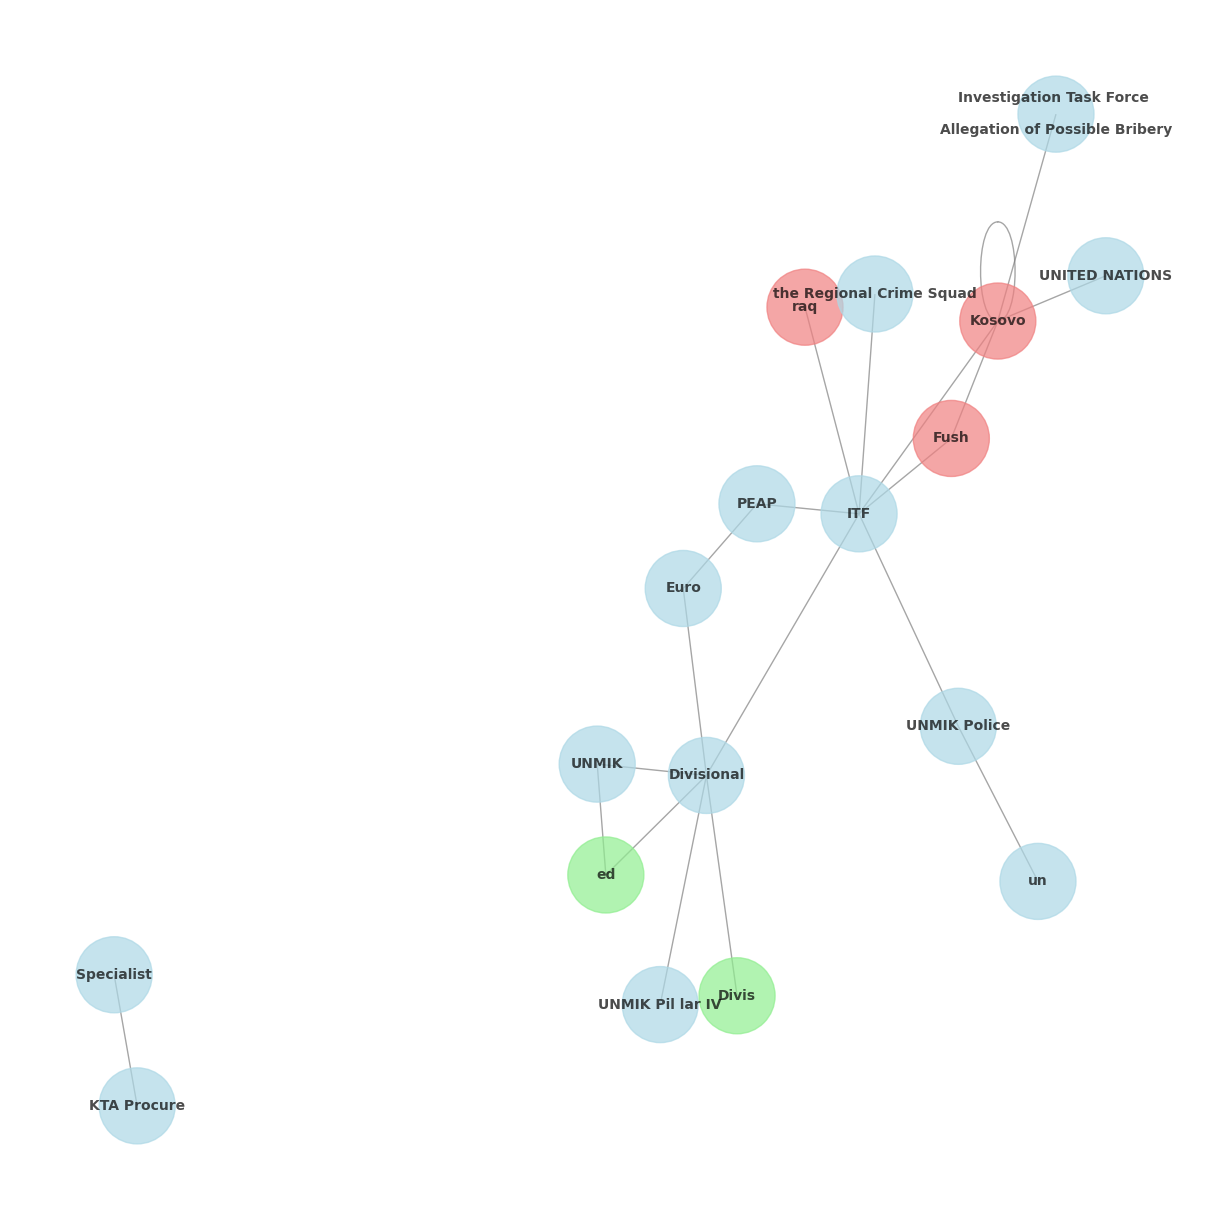

Graph for '49.pdf' saved as 'analysis_results/49.pdf_graph.png'


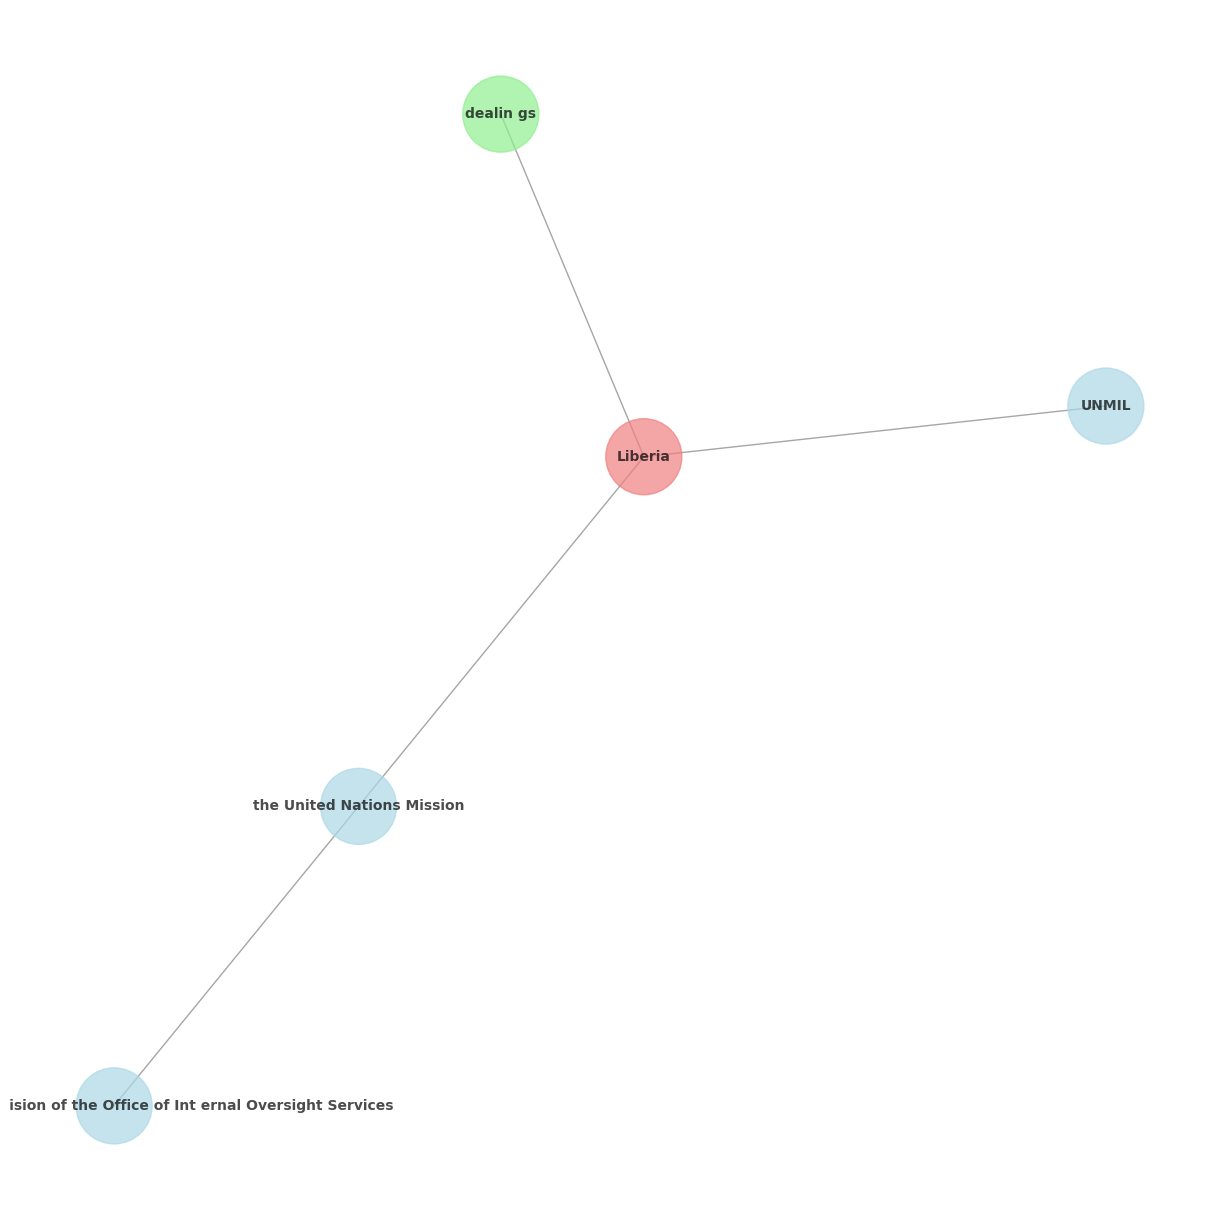

Graph for '60.pdf' saved as 'analysis_results/60.pdf_graph.png'


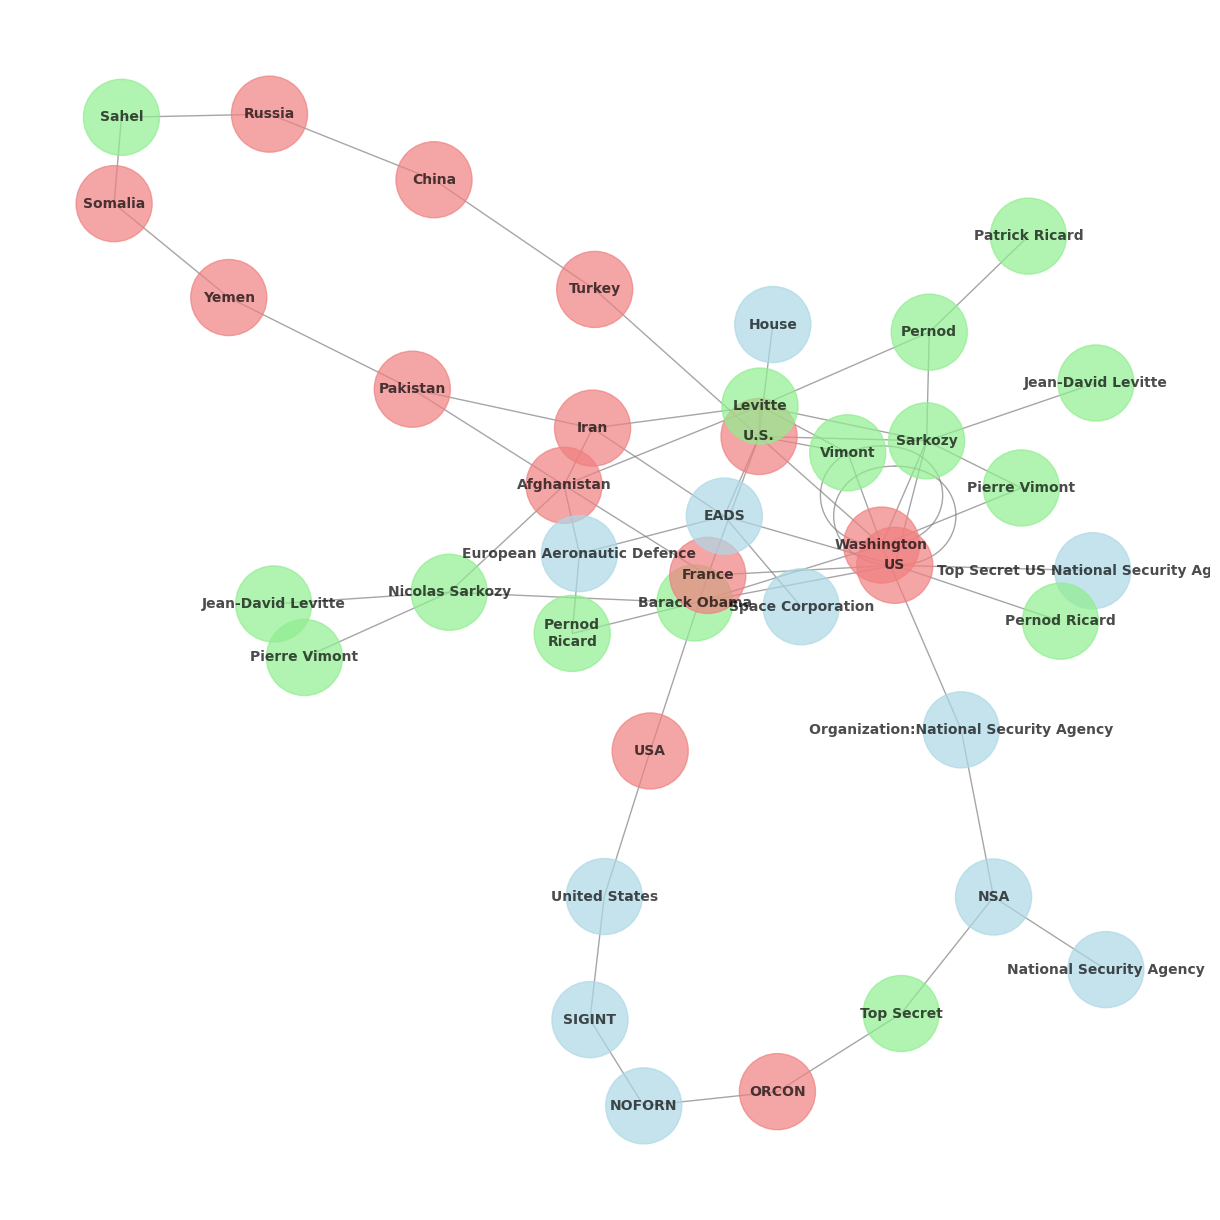

Graph for '89.pdf' saved as 'analysis_results/89.pdf_graph.png'


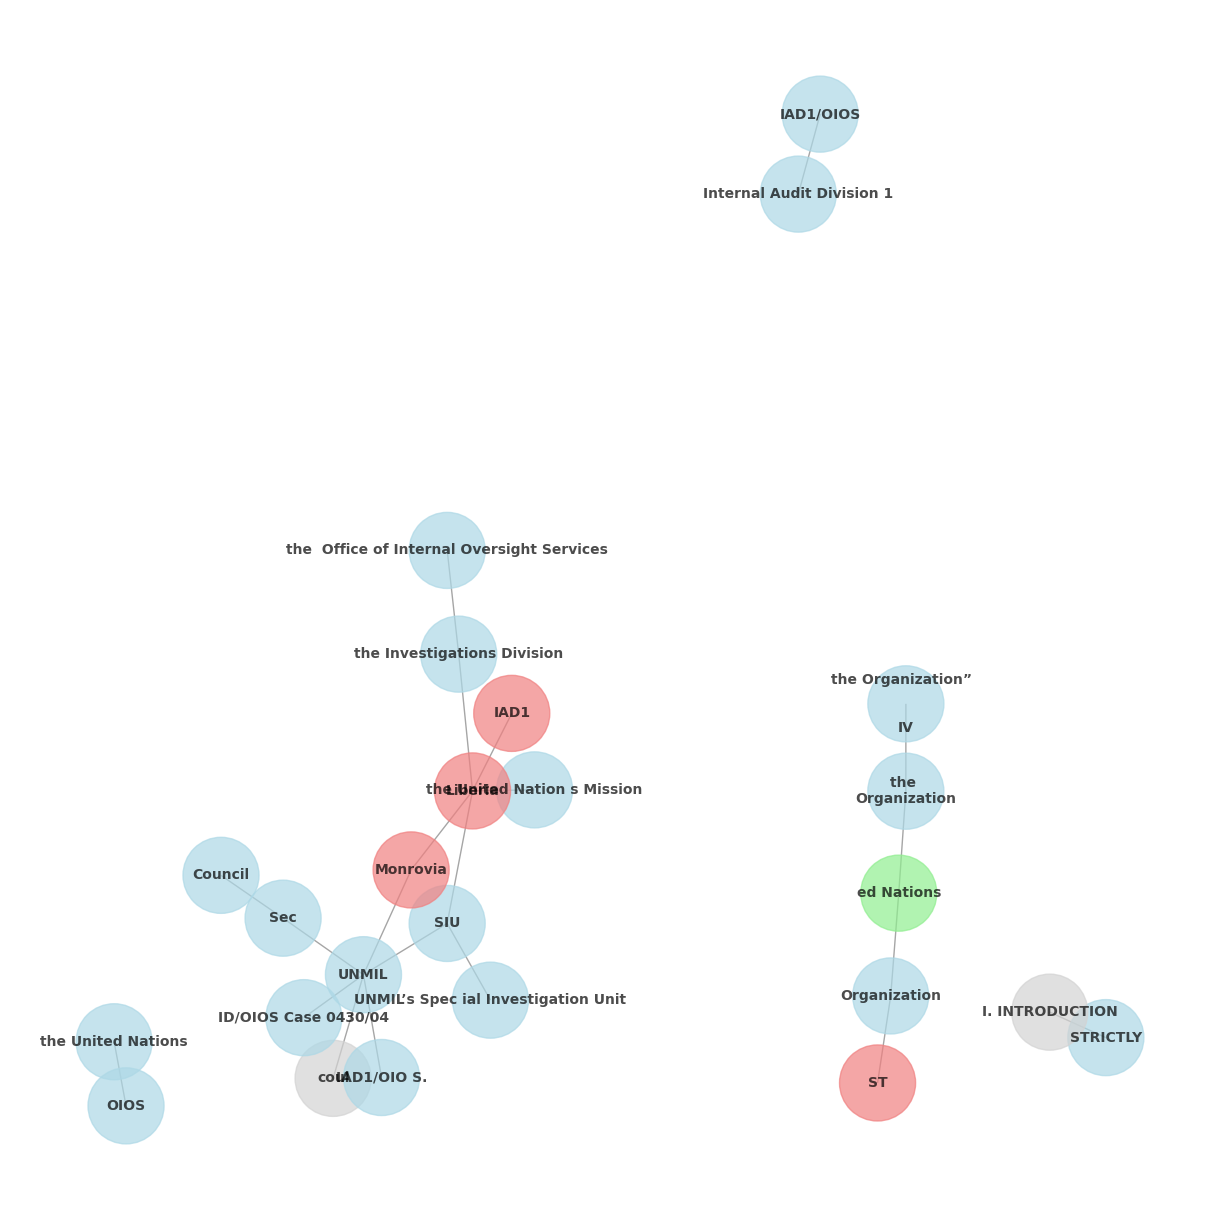

Graph for '63.pdf' saved as 'analysis_results/63.pdf_graph.png'


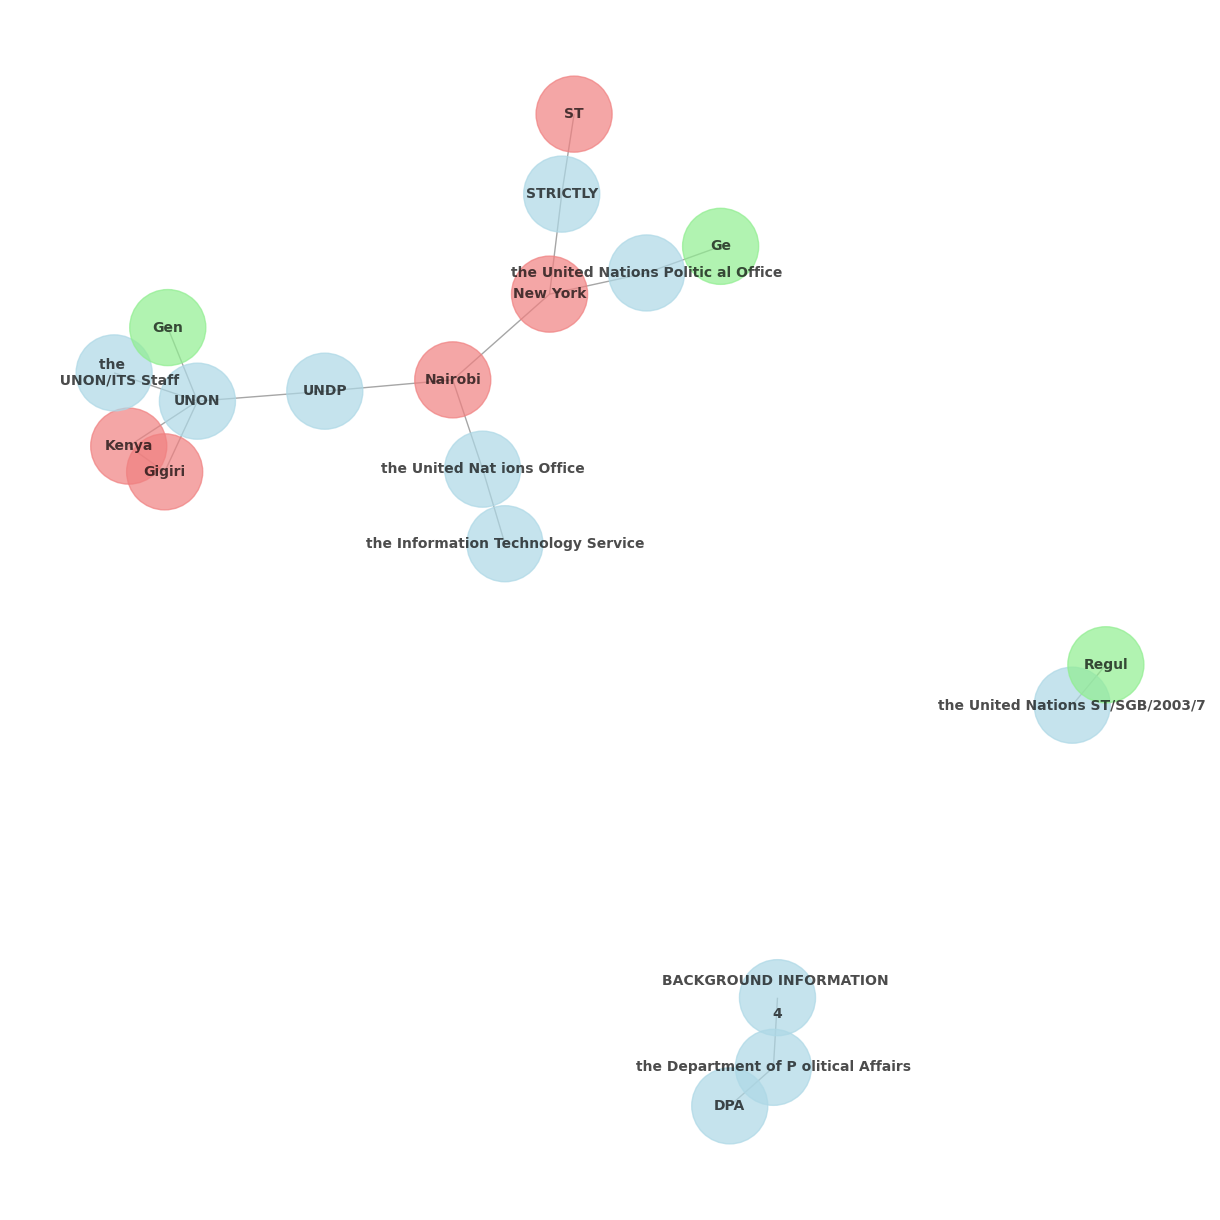

Graph for '73.pdf' saved as 'analysis_results/73.pdf_graph.png'


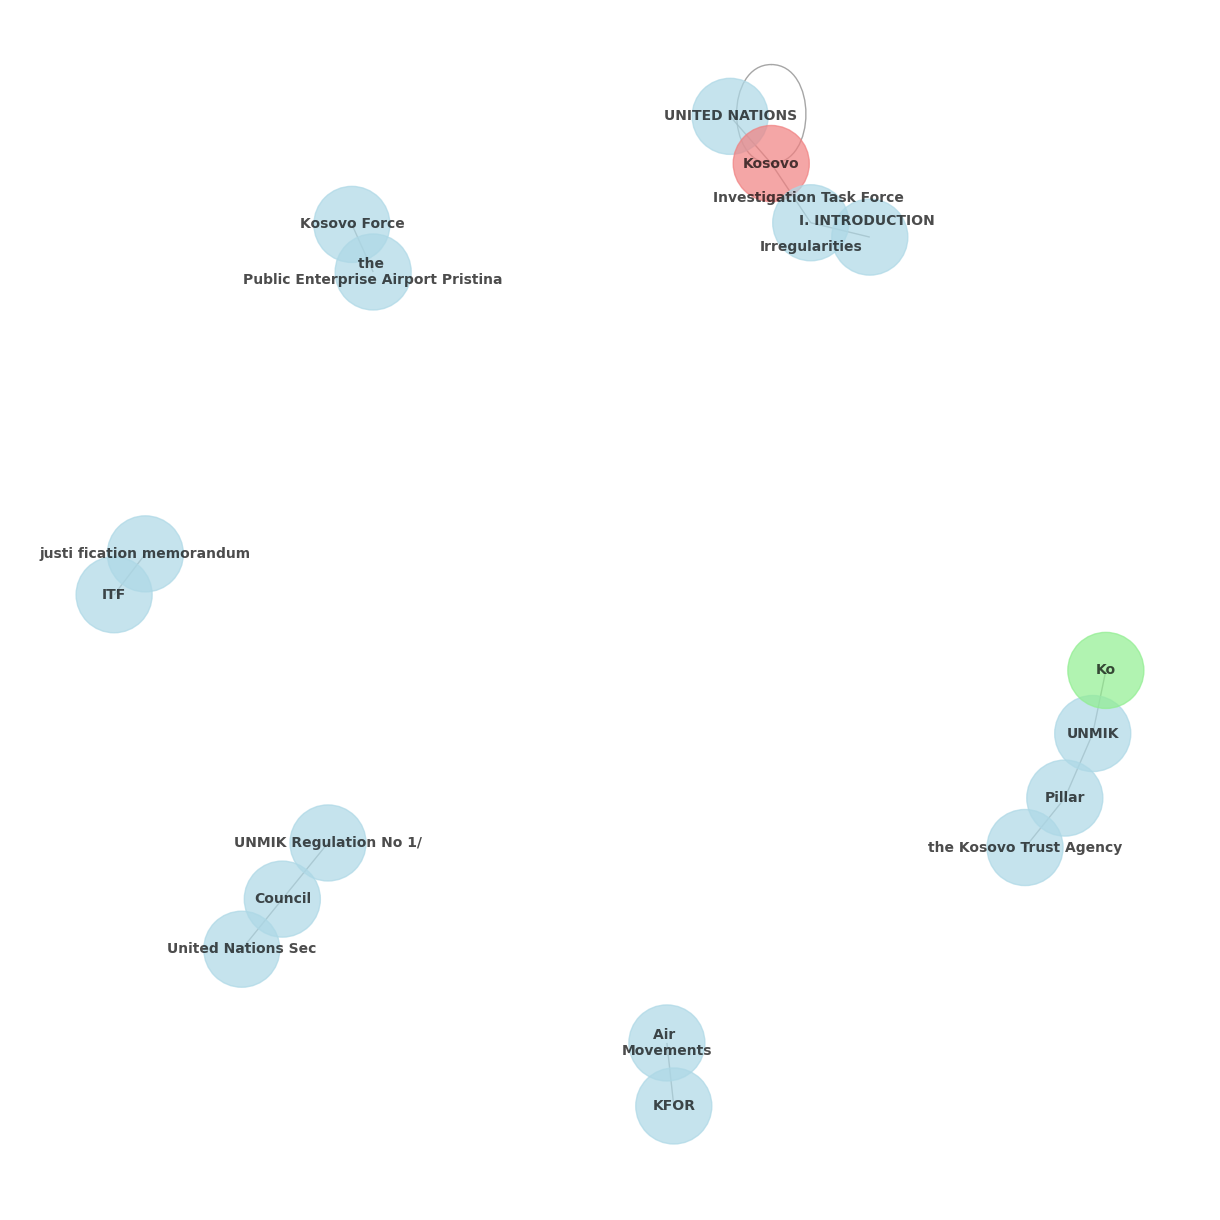

Graph for '9.pdf' saved as 'analysis_results/9.pdf_graph.png'


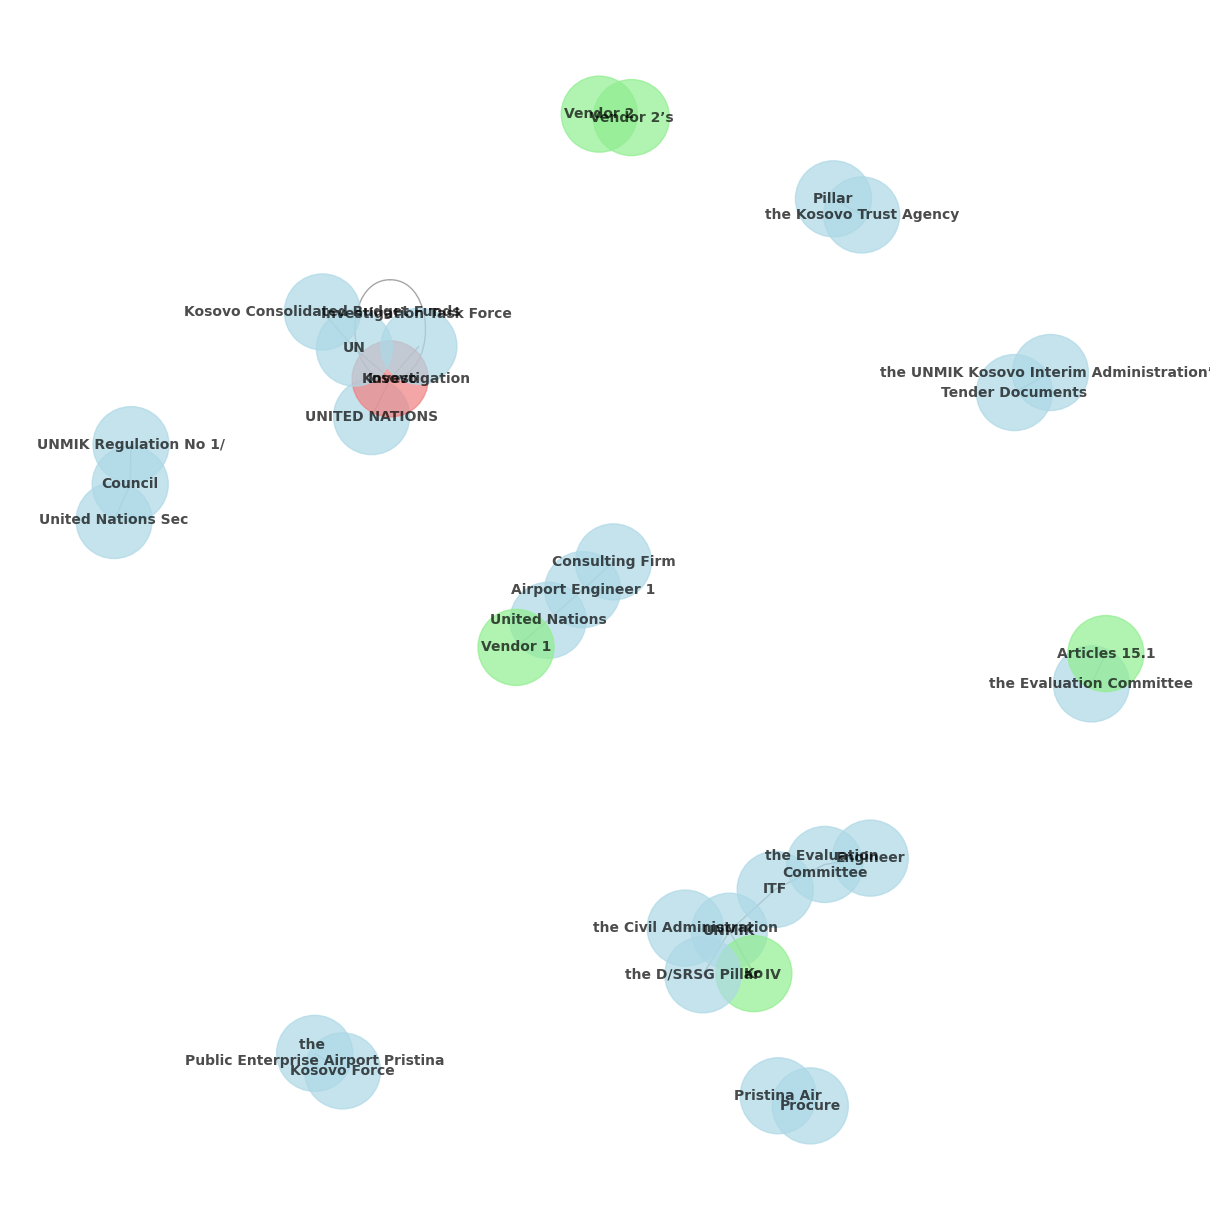

Graph for '8.pdf' saved as 'analysis_results/8.pdf_graph.png'


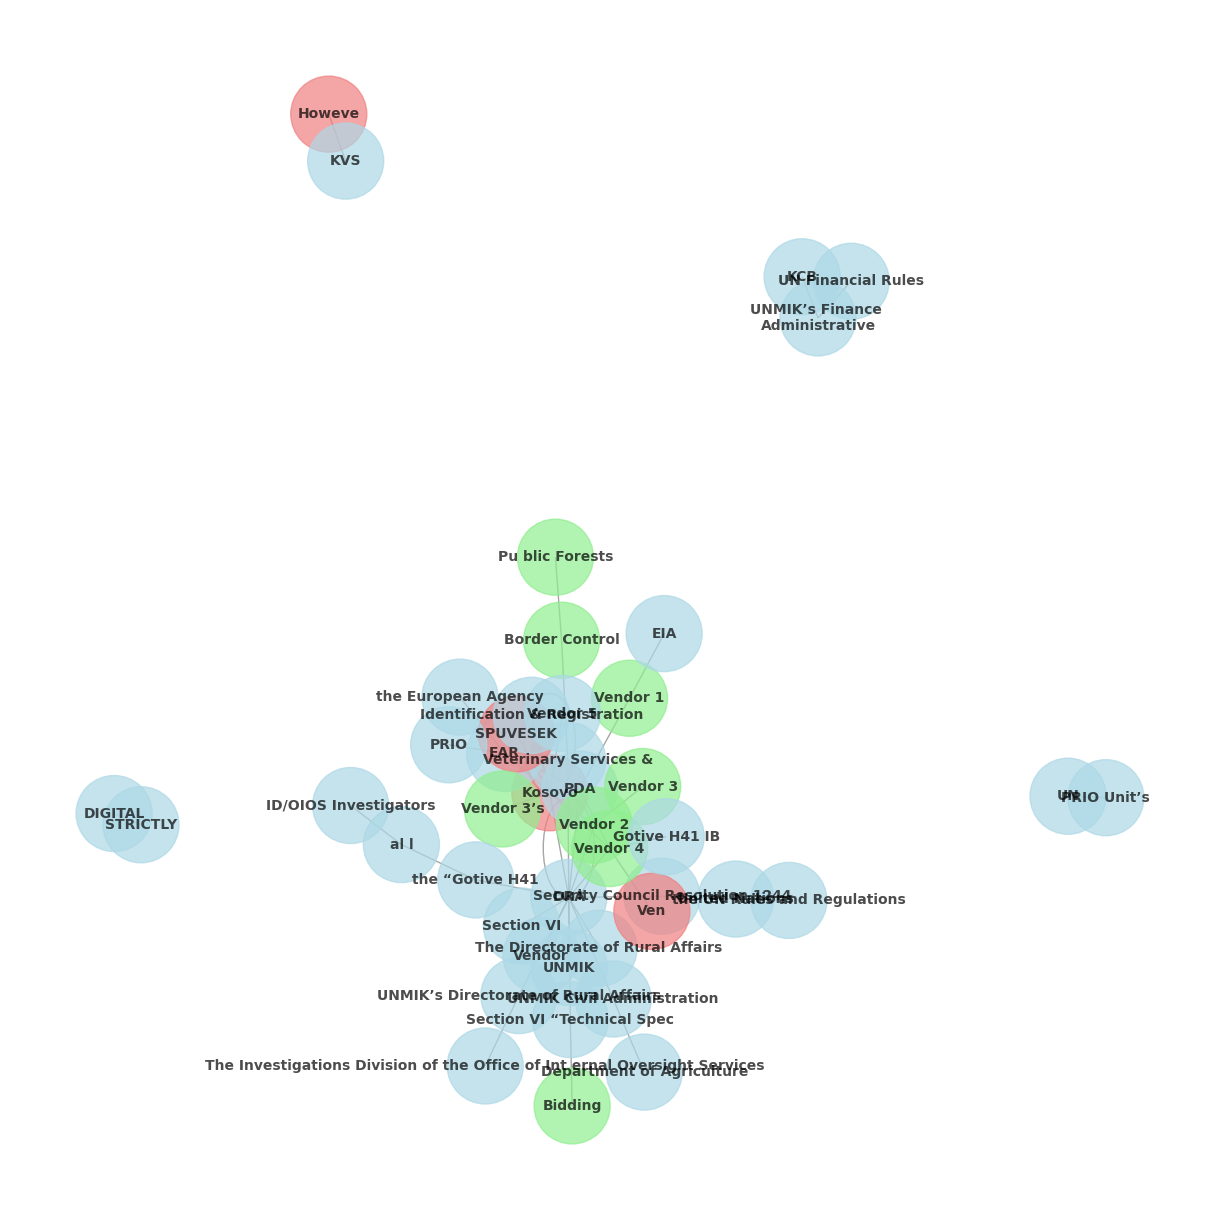

Graph for '16.pdf' saved as 'analysis_results/16.pdf_graph.png'


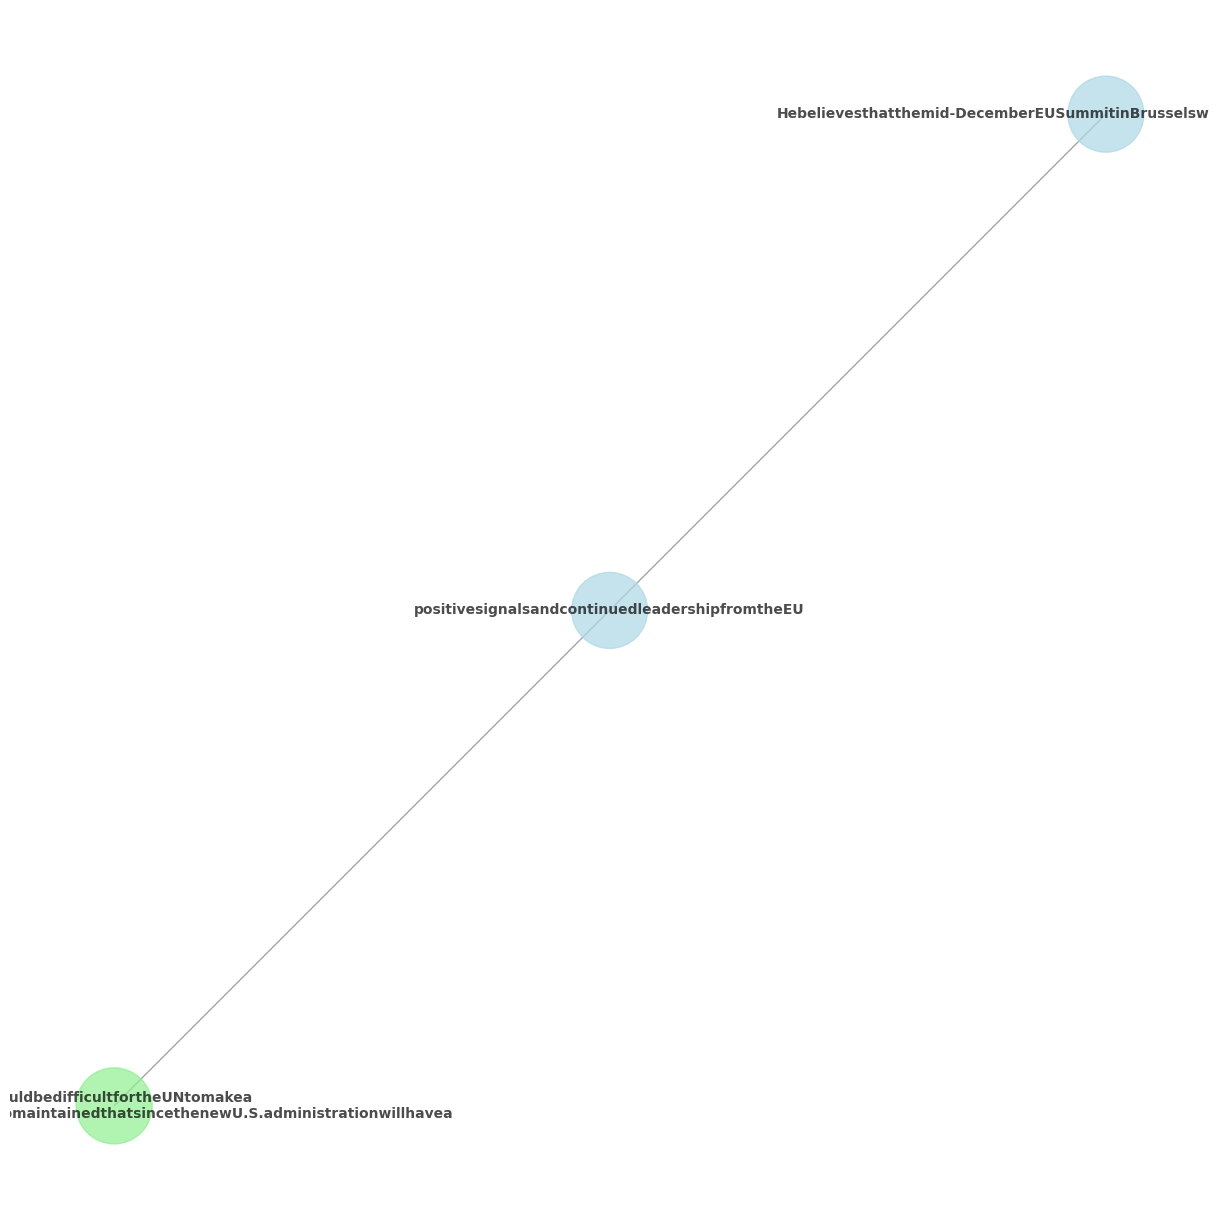

Graph for '114.pdf' saved as 'analysis_results/114.pdf_graph.png'


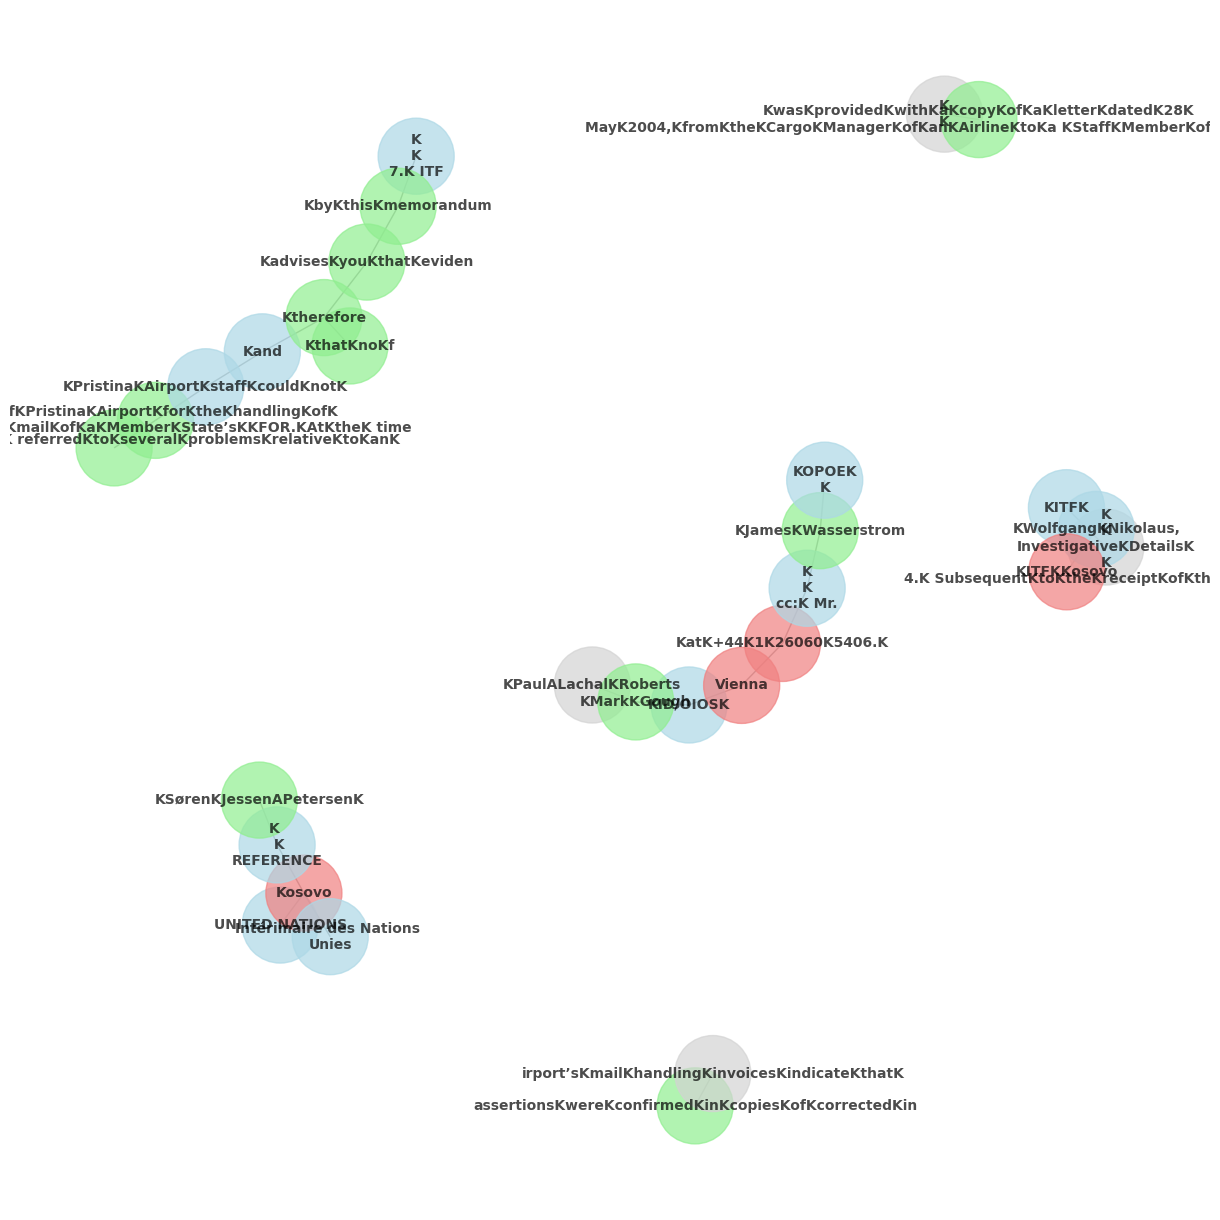

Graph for '15.pdf' saved as 'analysis_results/15.pdf_graph.png'


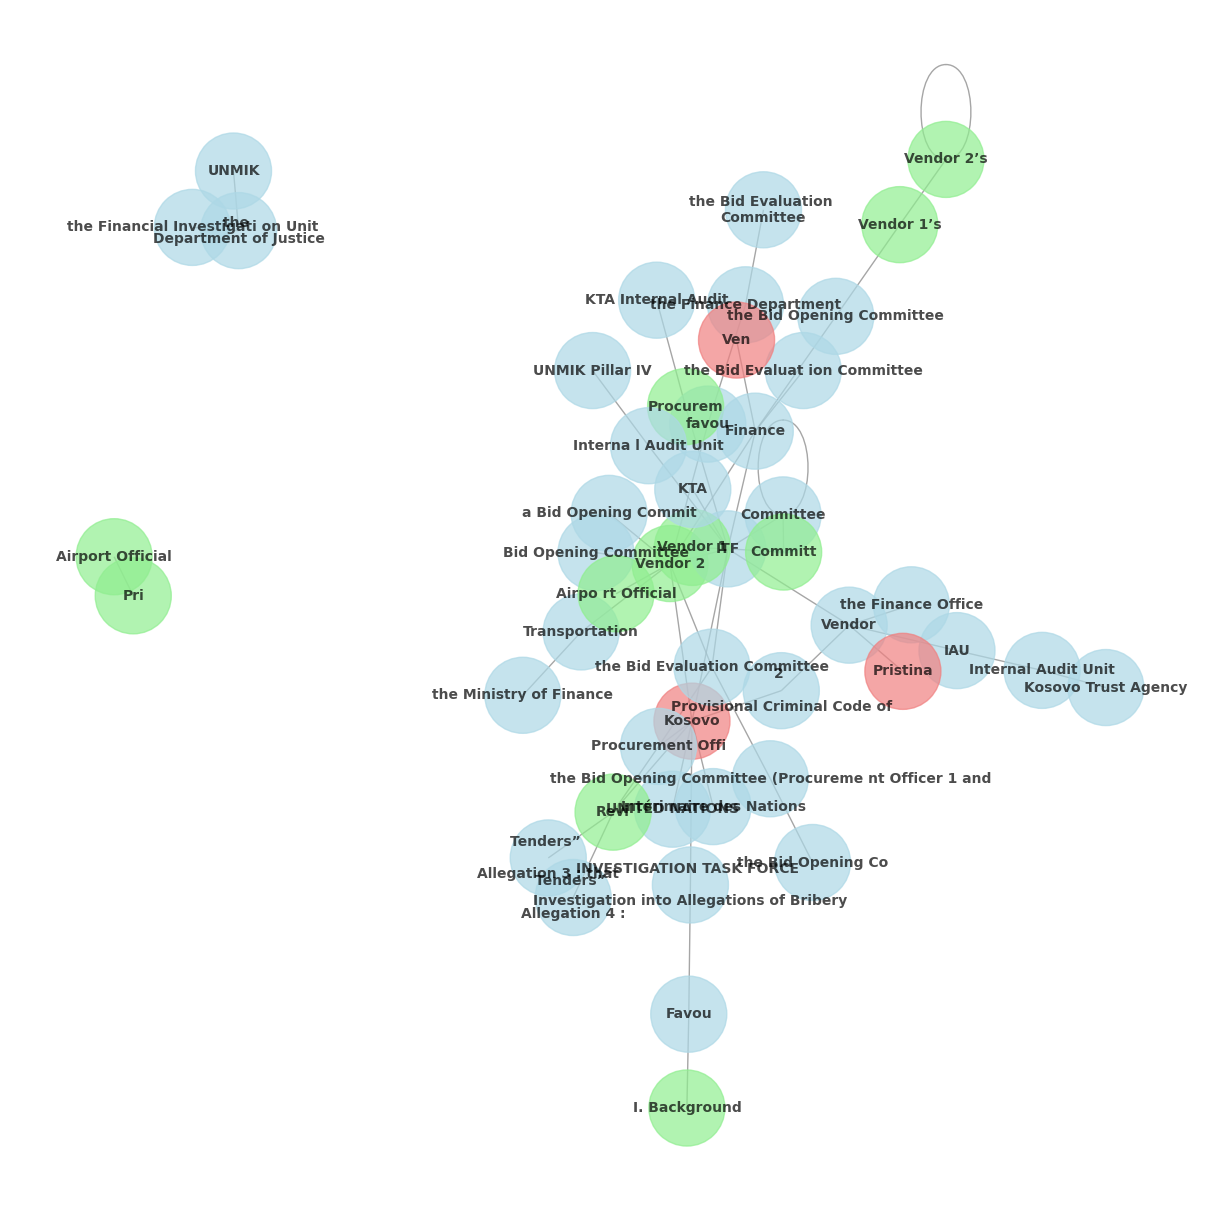

Graph for '14.pdf' saved as 'analysis_results/14.pdf_graph.png'


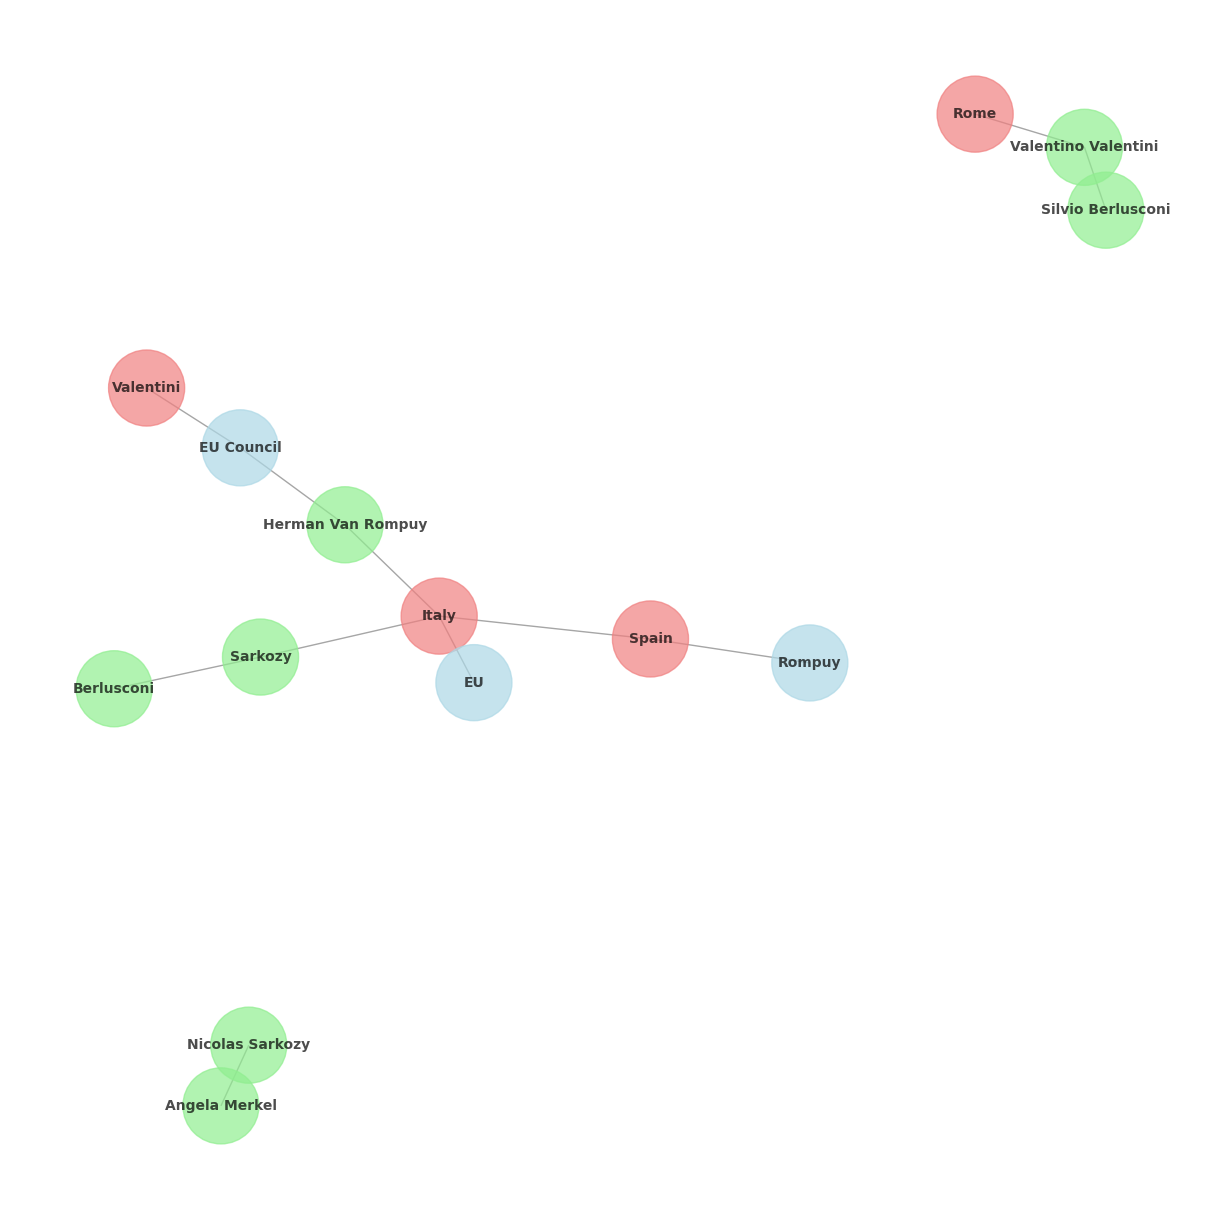

Graph for '111.pdf' saved as 'analysis_results/111.pdf_graph.png'


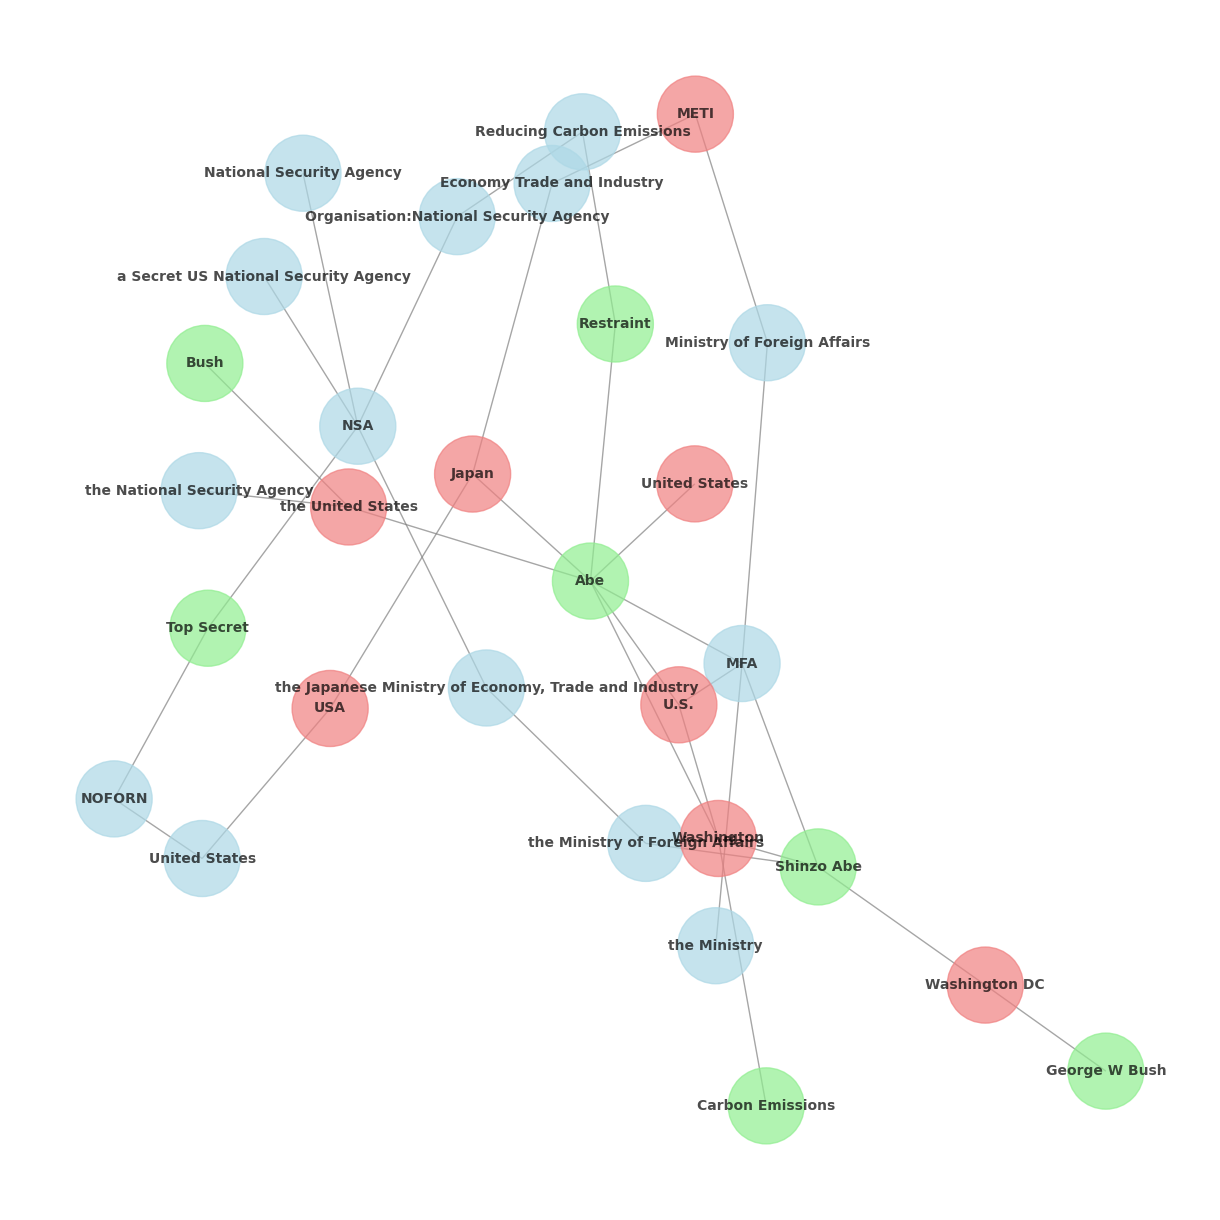

Graph for '105.pdf' saved as 'analysis_results/105.pdf_graph.png'


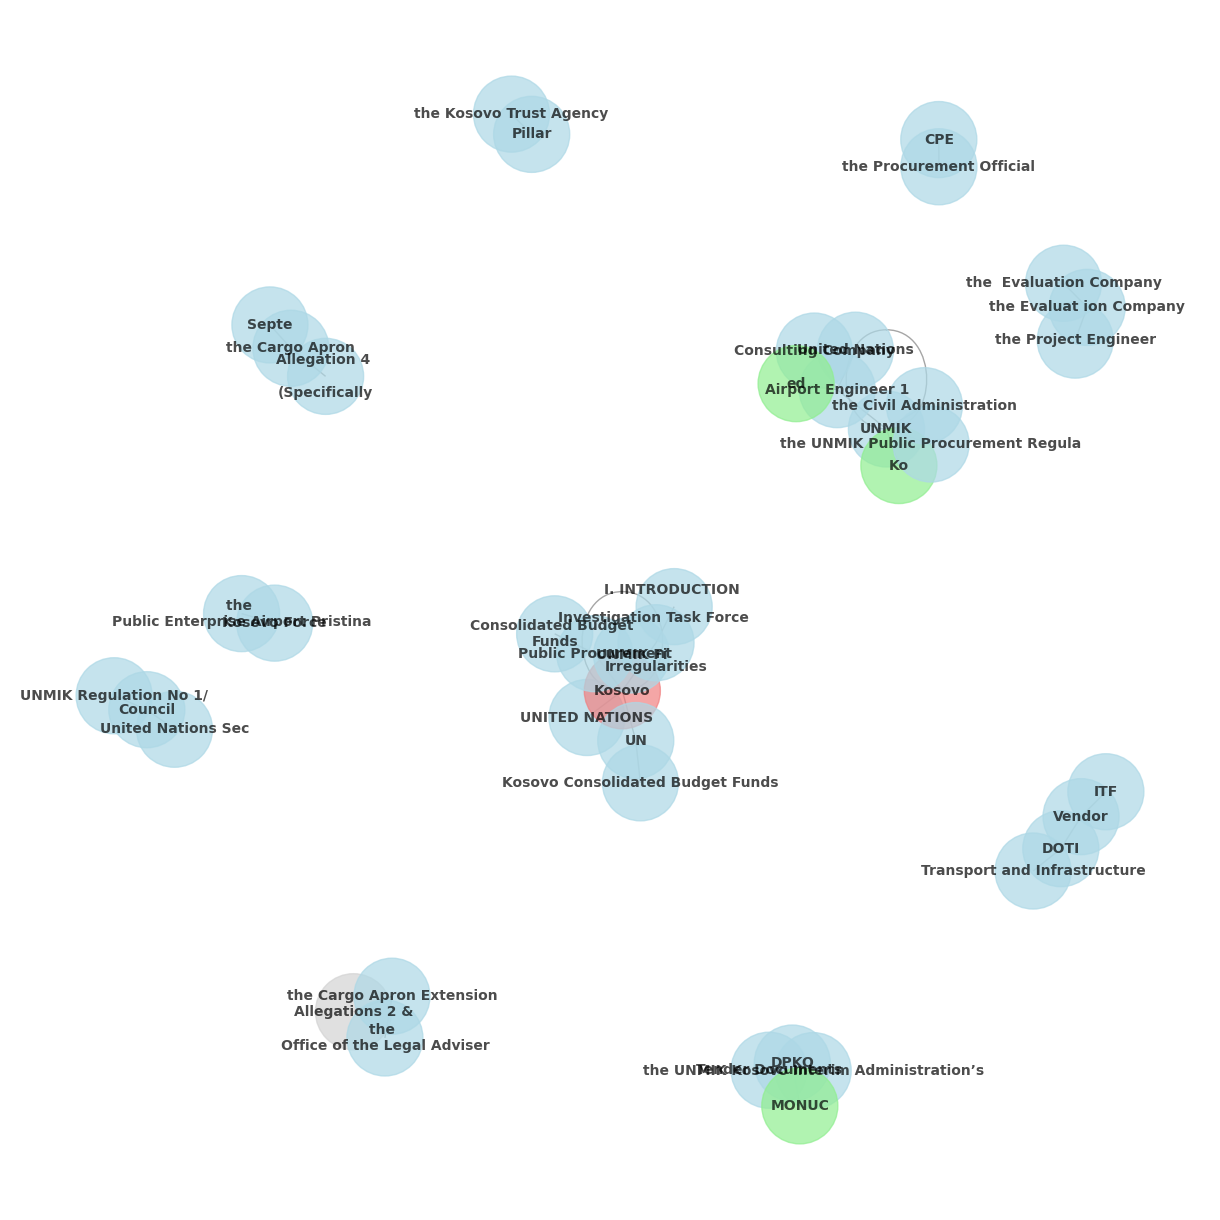

Graph for '10.pdf' saved as 'analysis_results/10.pdf_graph.png'


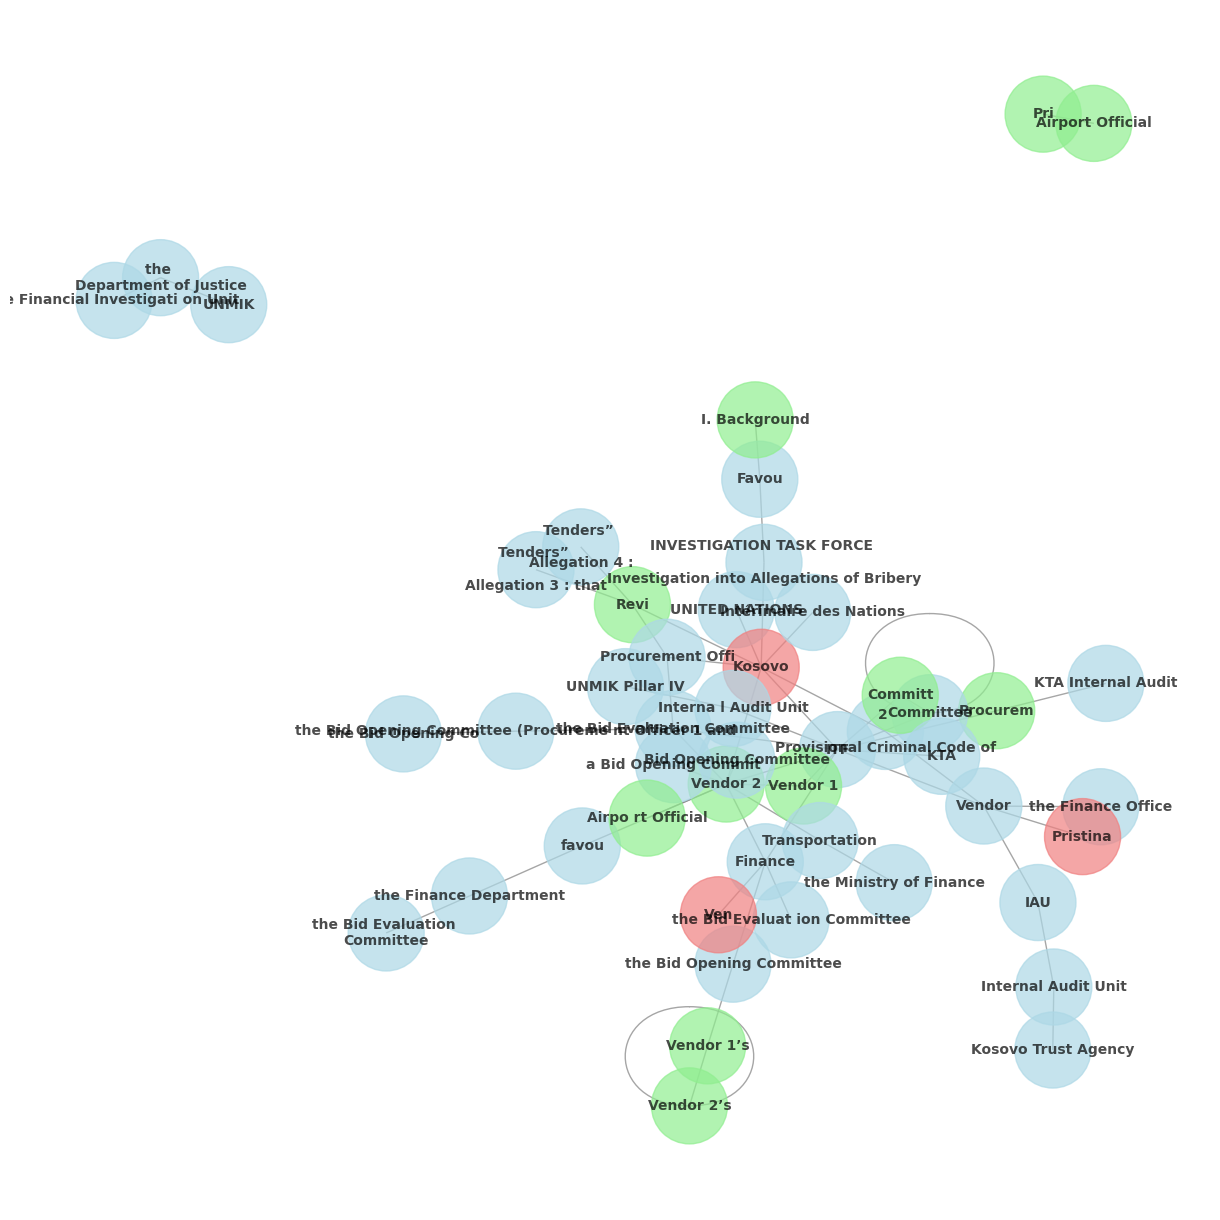

Graph for '38.pdf' saved as 'analysis_results/38.pdf_graph.png'


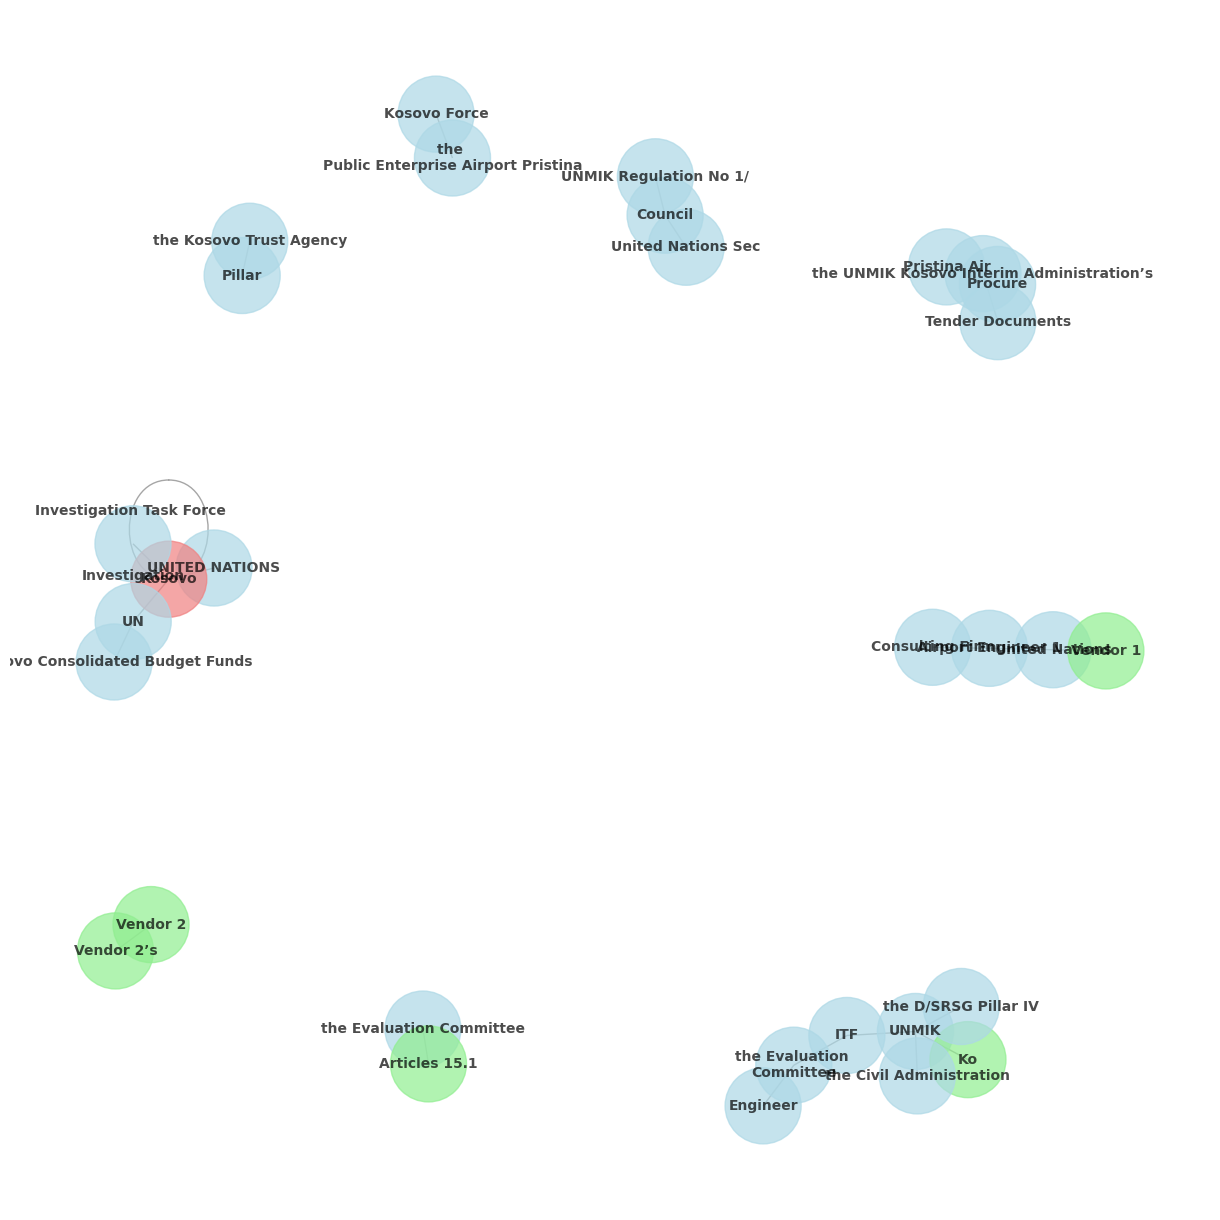

Graph for '39.pdf' saved as 'analysis_results/39.pdf_graph.png'


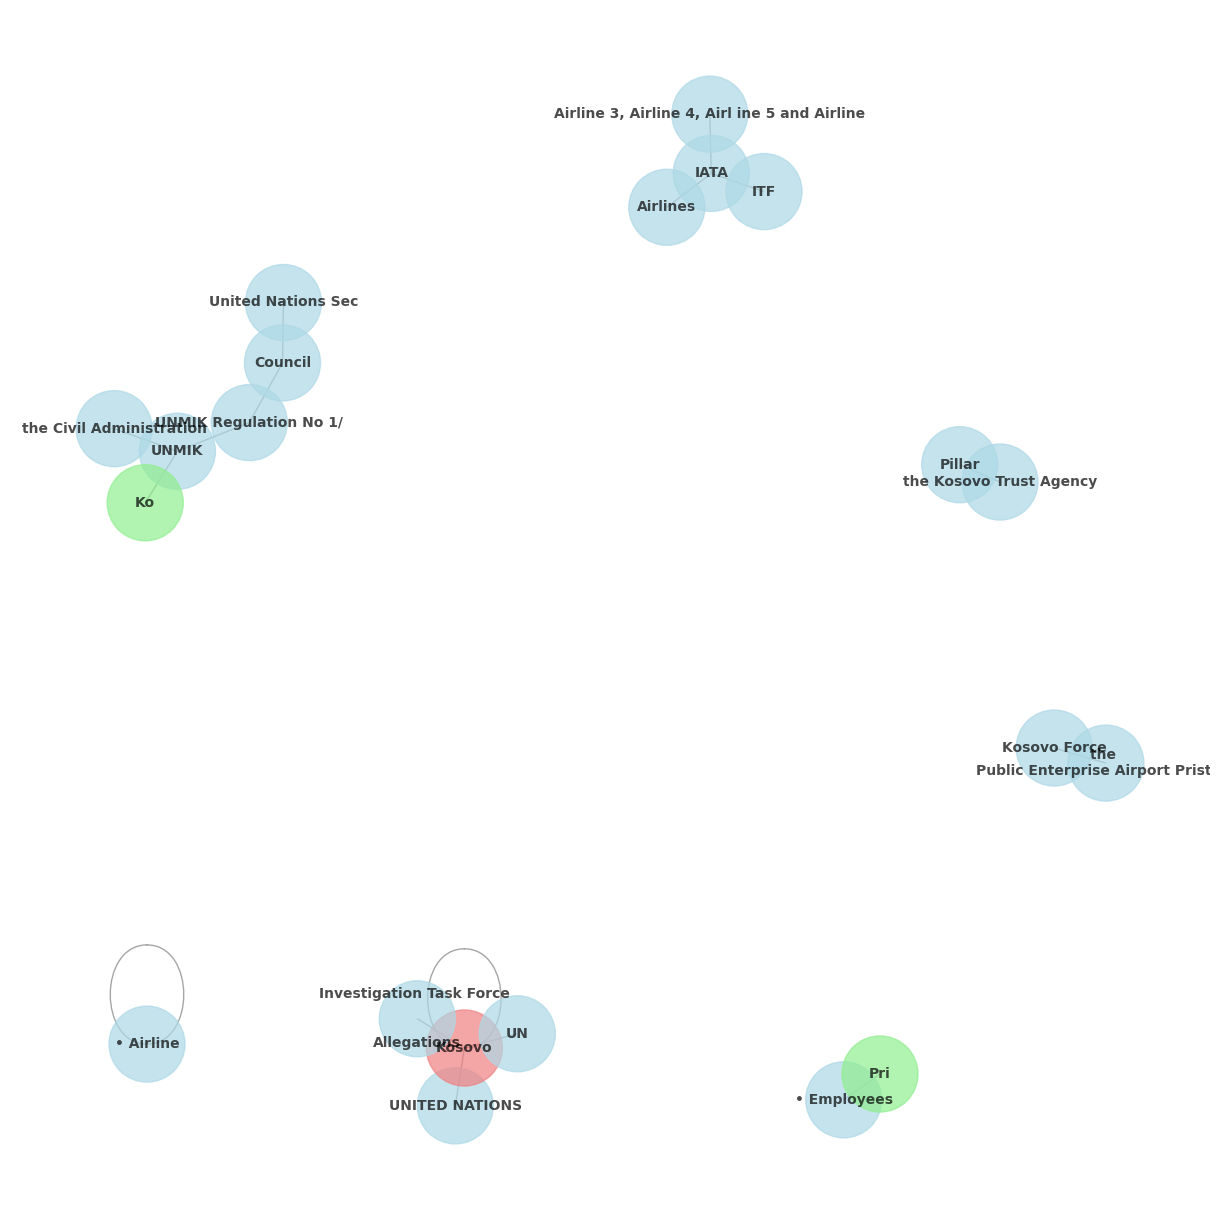

Graph for '11.pdf' saved as 'analysis_results/11.pdf_graph.png'


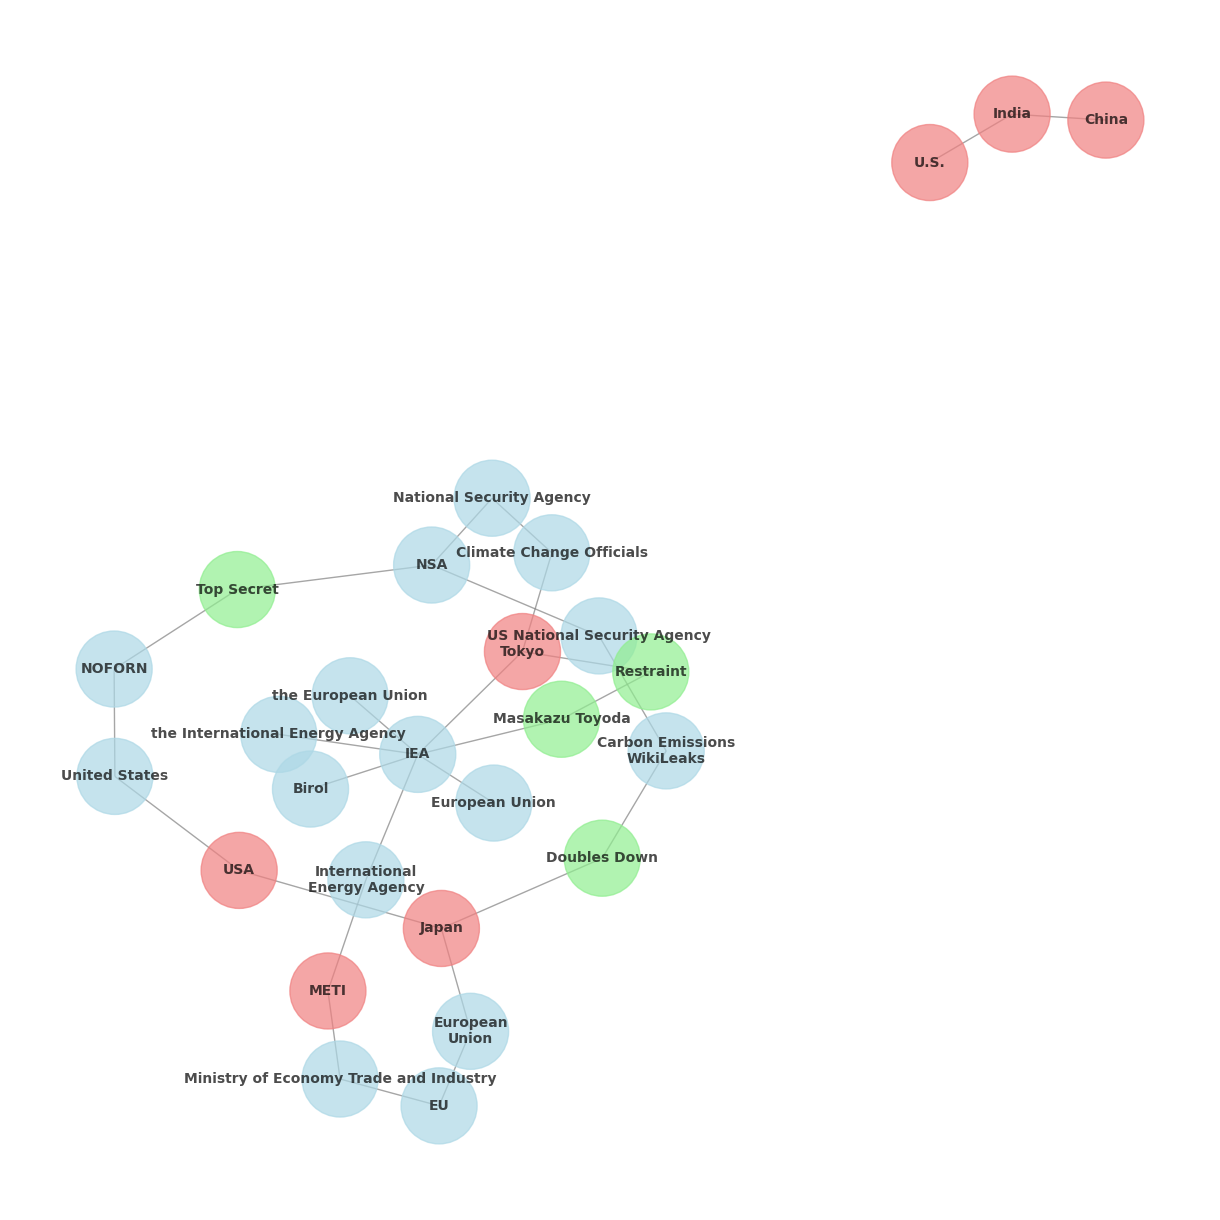

Graph for '106.pdf' saved as 'analysis_results/106.pdf_graph.png'


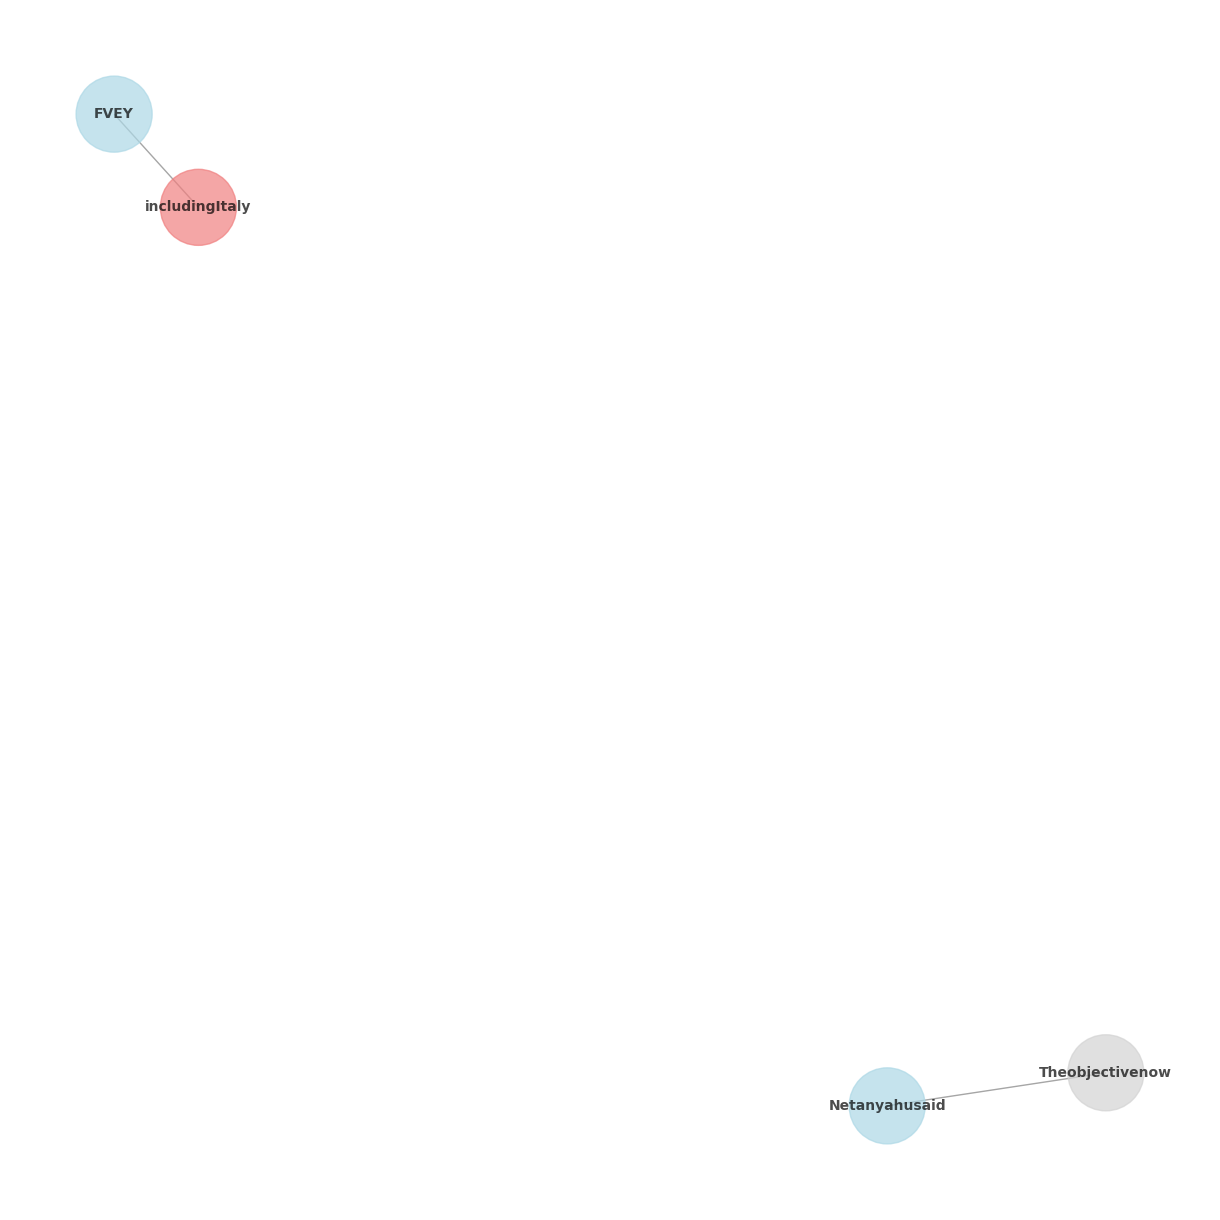

Graph for '112.pdf' saved as 'analysis_results/112.pdf_graph.png'


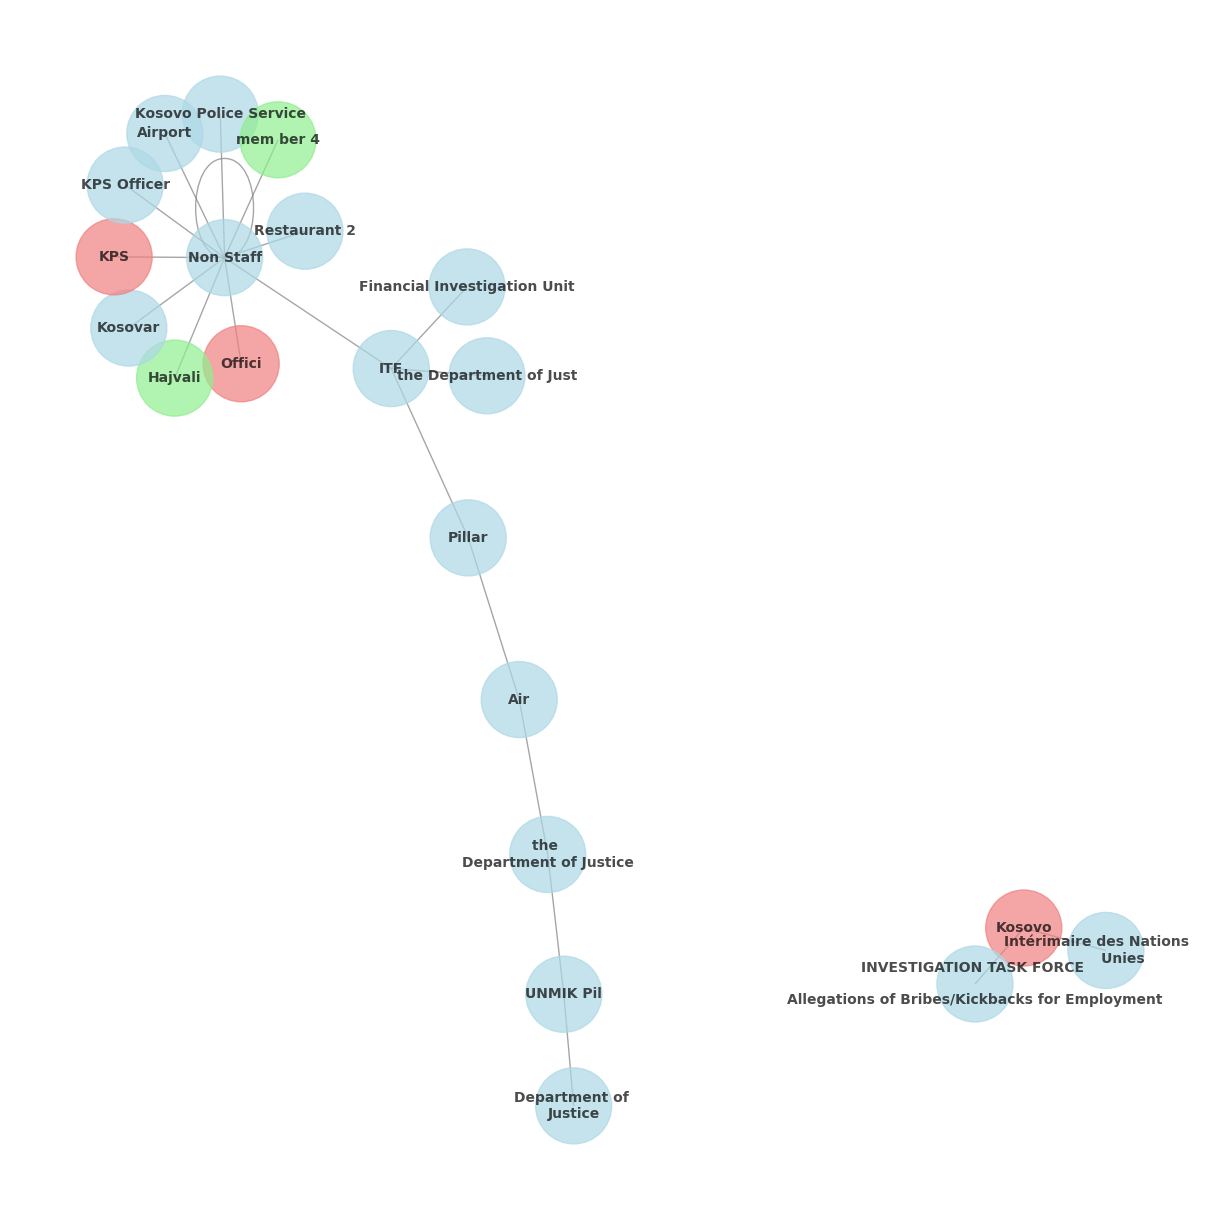

Graph for '13.pdf' saved as 'analysis_results/13.pdf_graph.png'


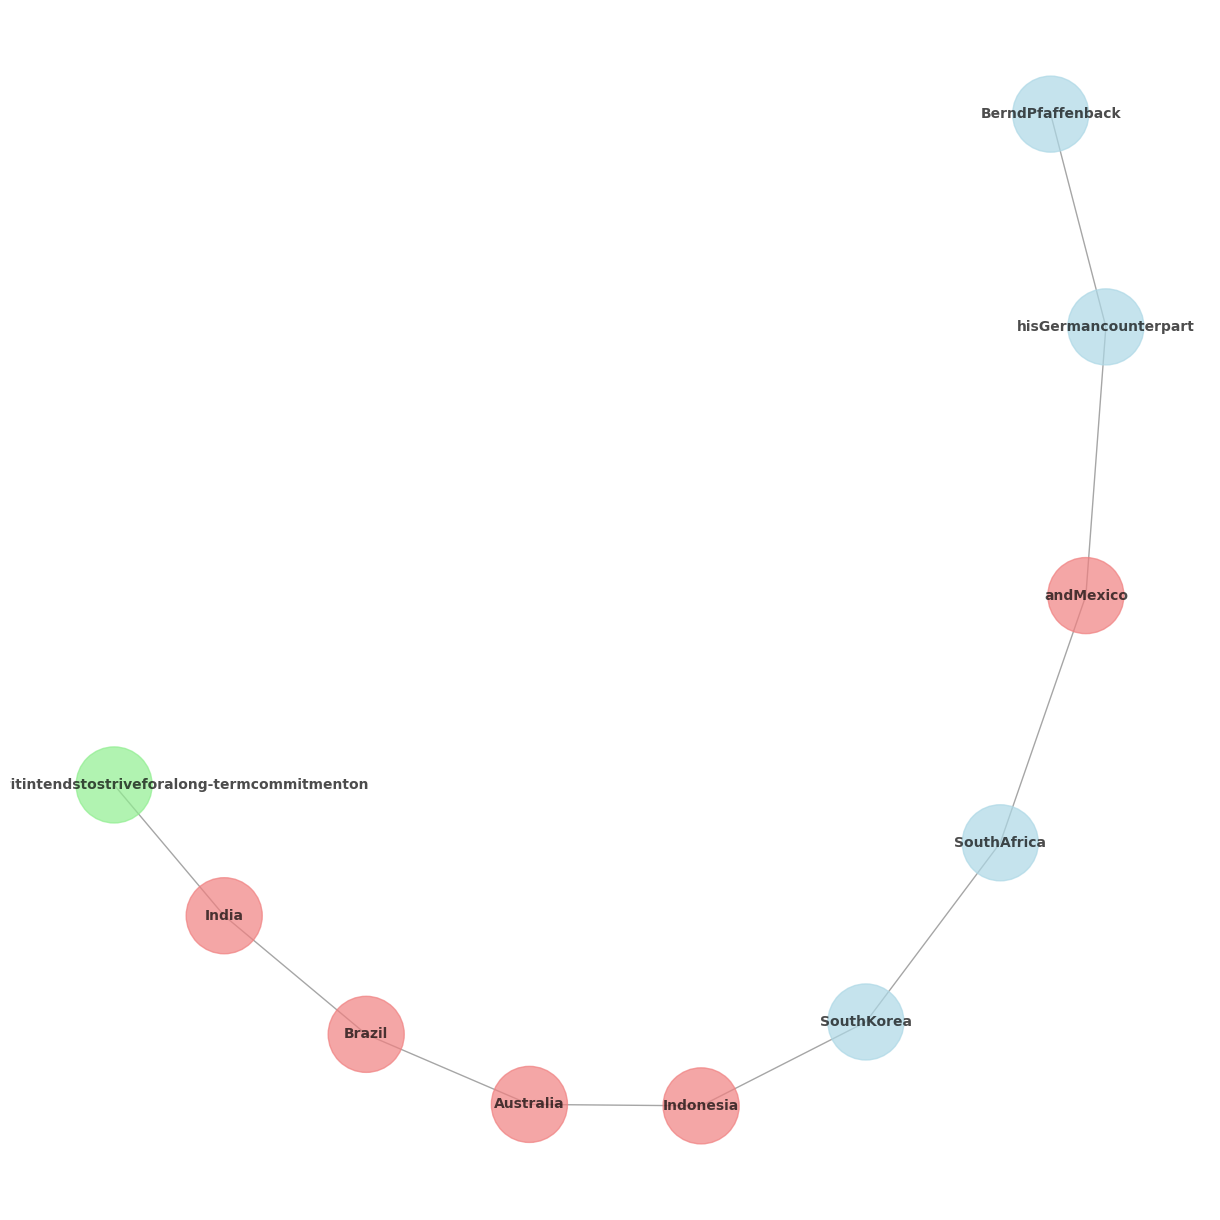

Graph for '113.pdf' saved as 'analysis_results/113.pdf_graph.png'


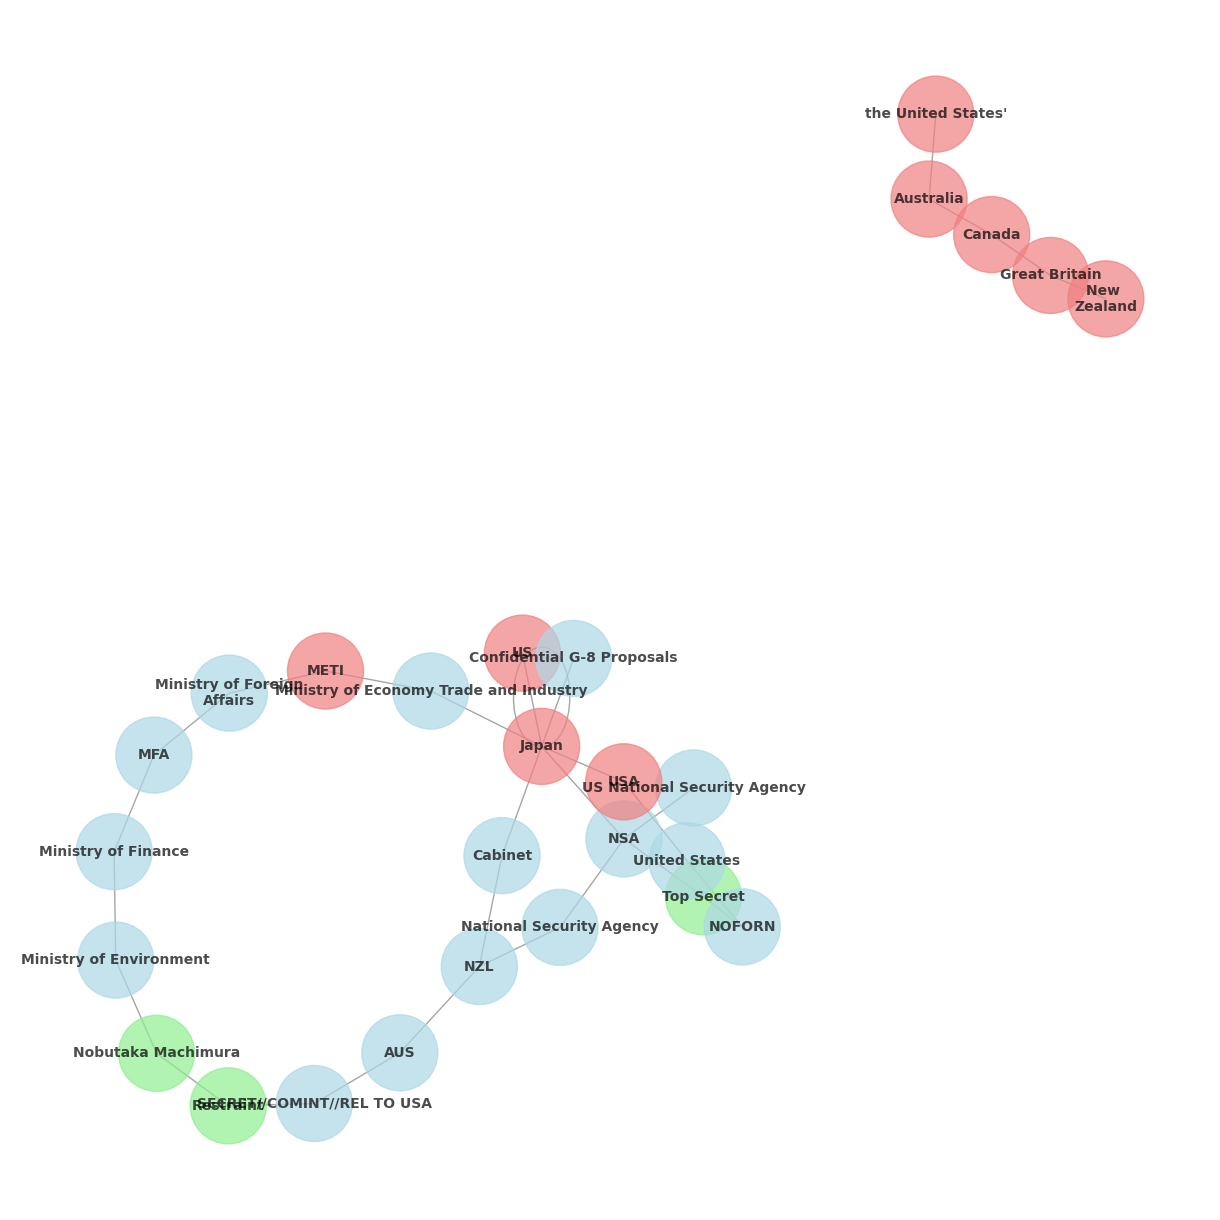

Graph for '107.pdf' saved as 'analysis_results/107.pdf_graph.png'


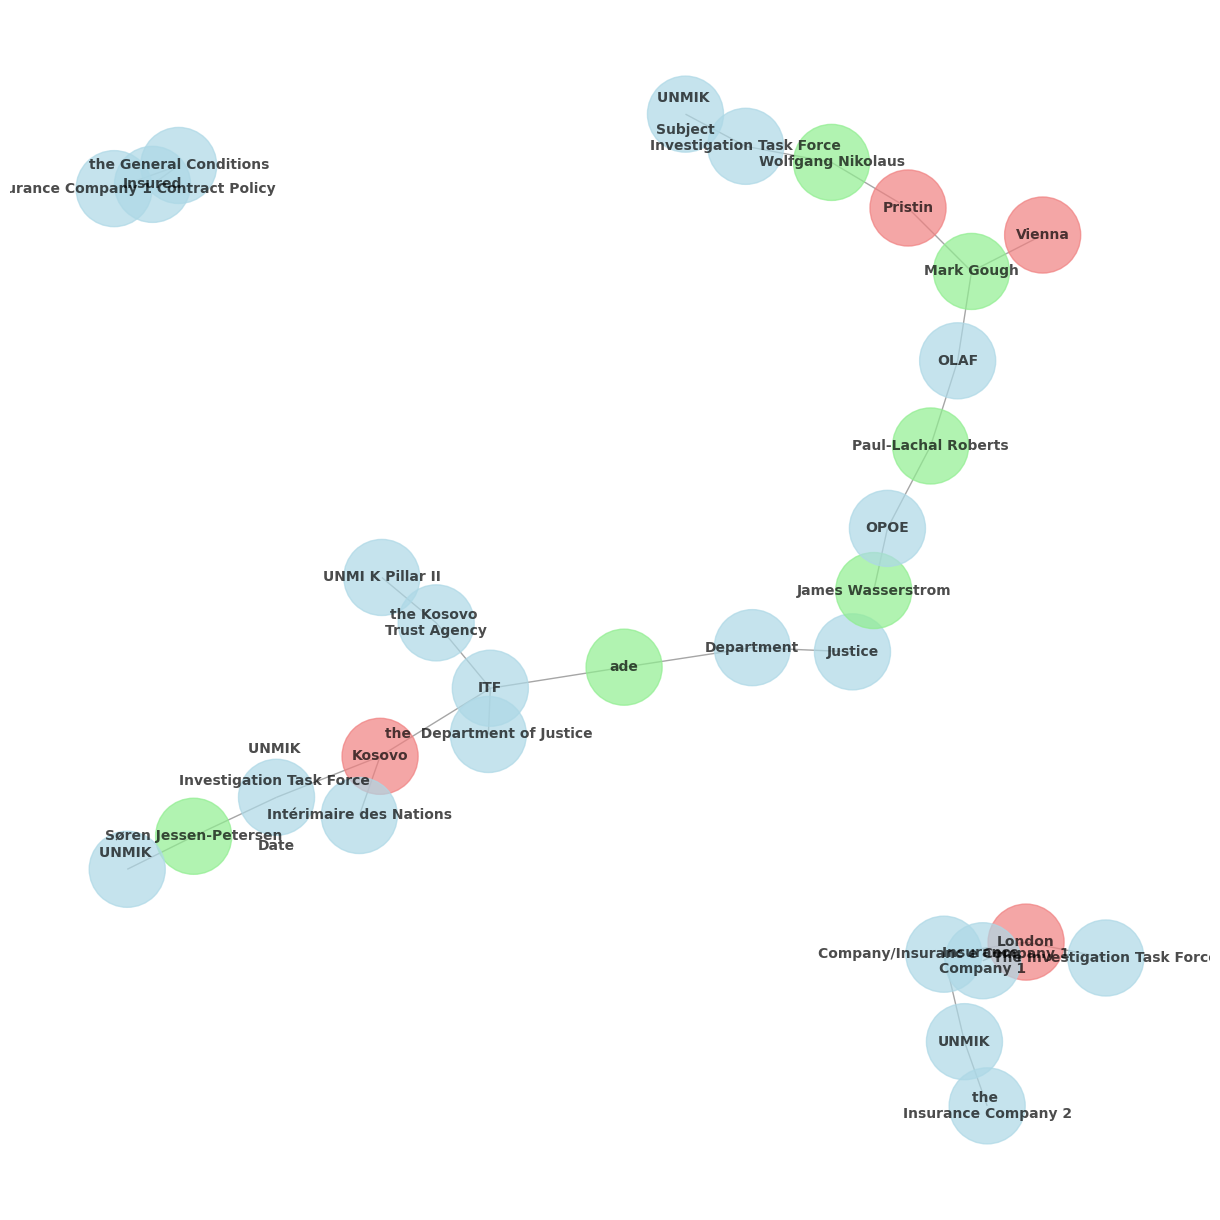

Graph for '36.pdf' saved as 'analysis_results/36.pdf_graph.png'


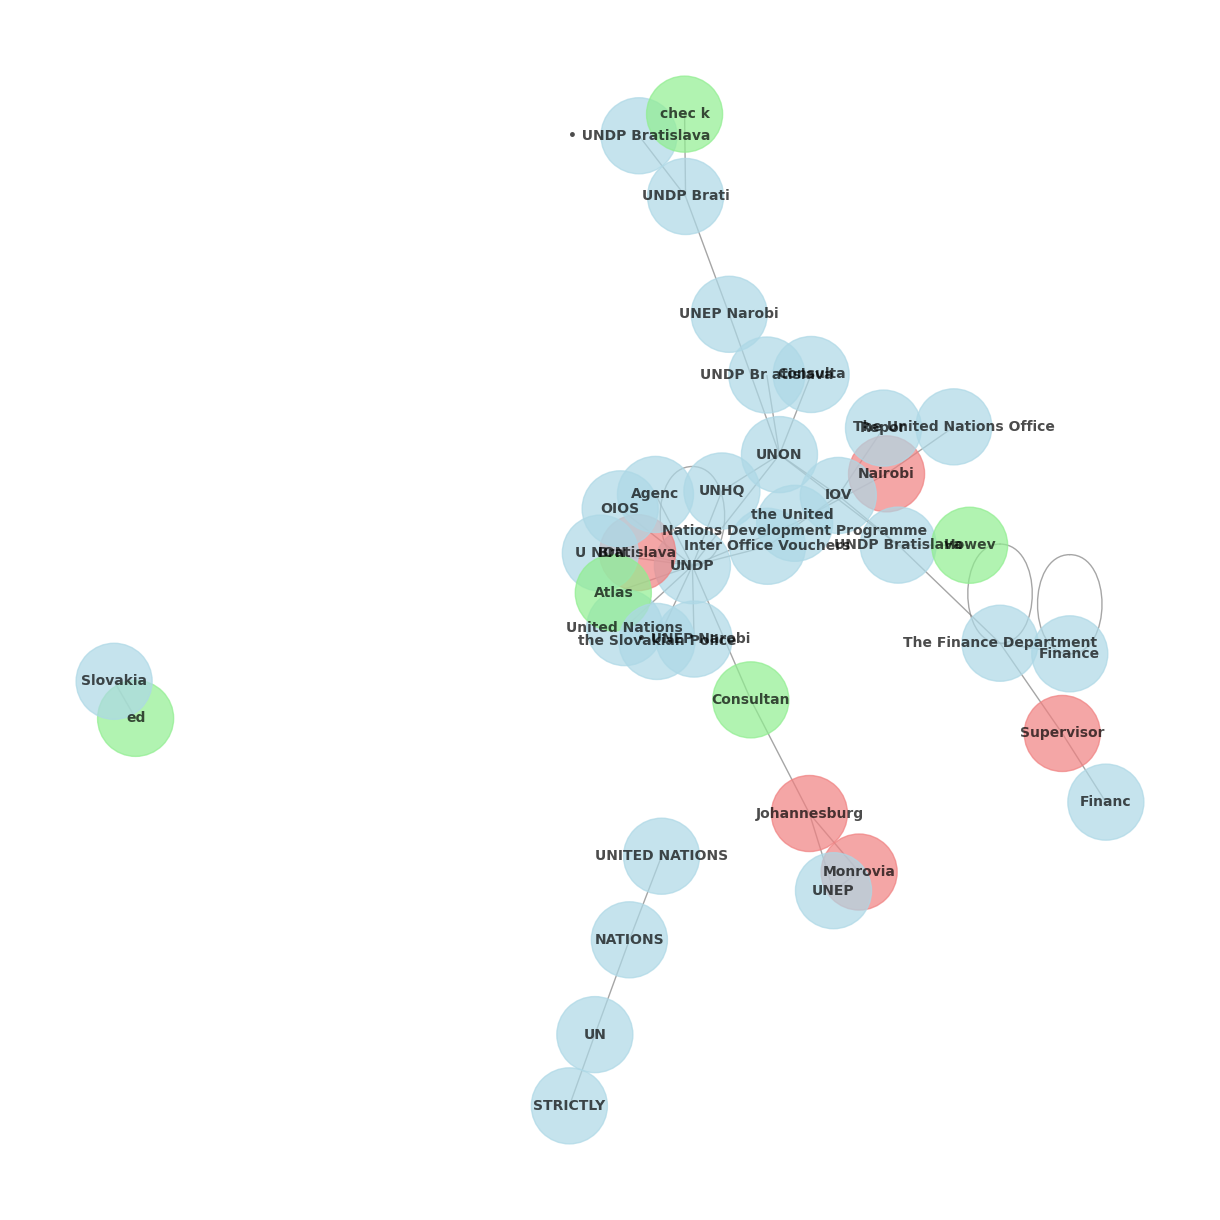

Graph for '21.pdf' saved as 'analysis_results/21.pdf_graph.png'


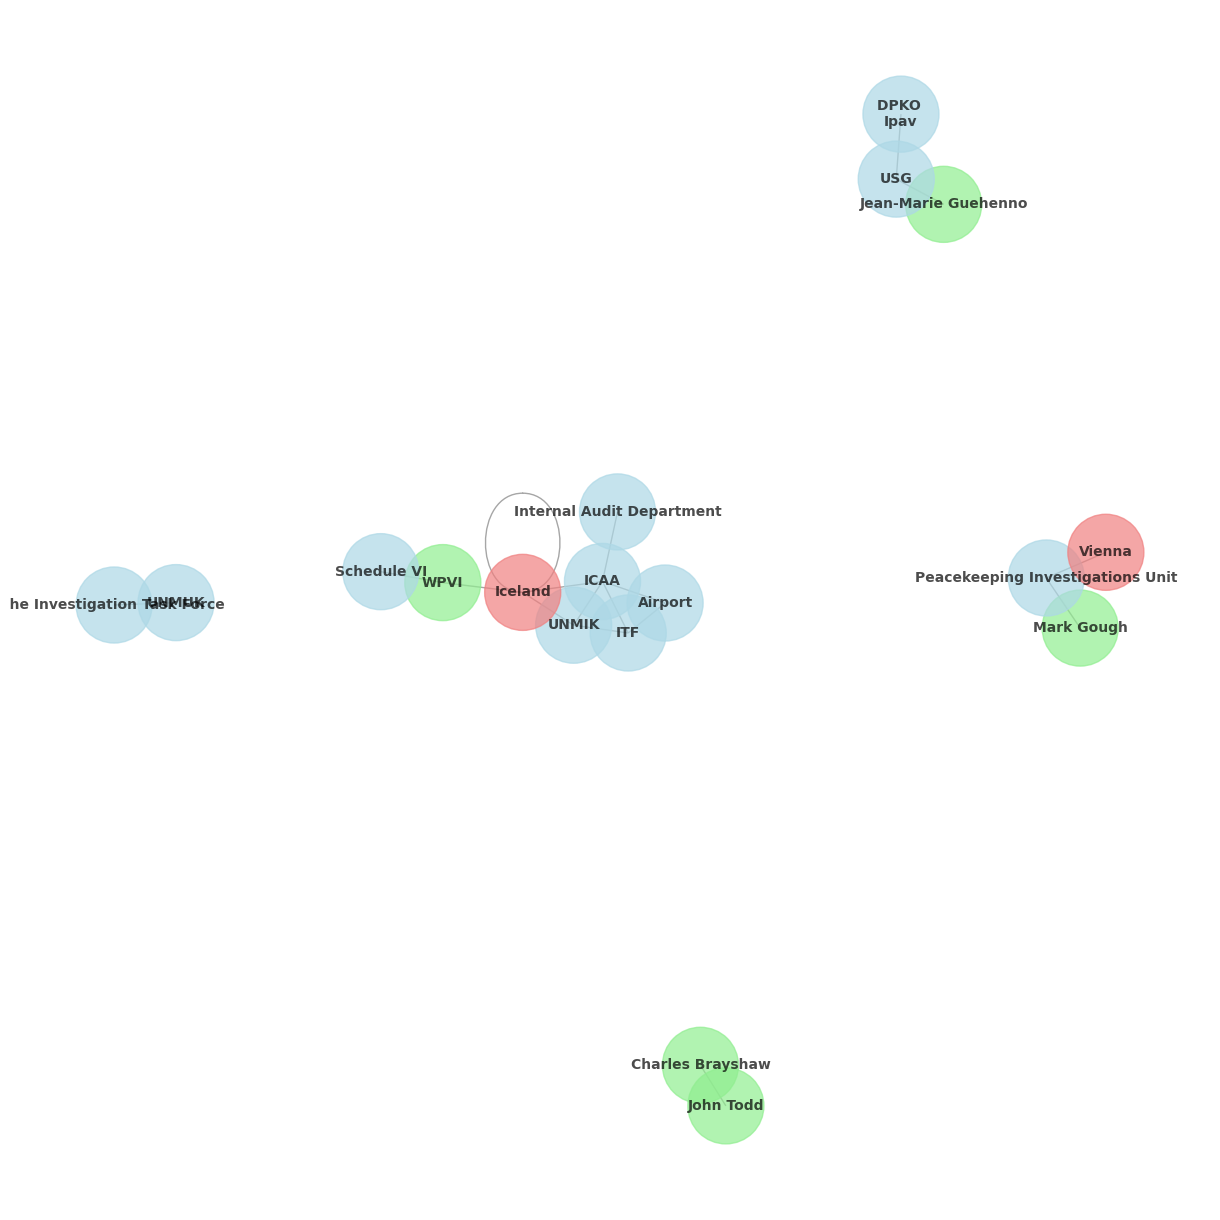

Graph for '35.pdf' saved as 'analysis_results/35.pdf_graph.png'


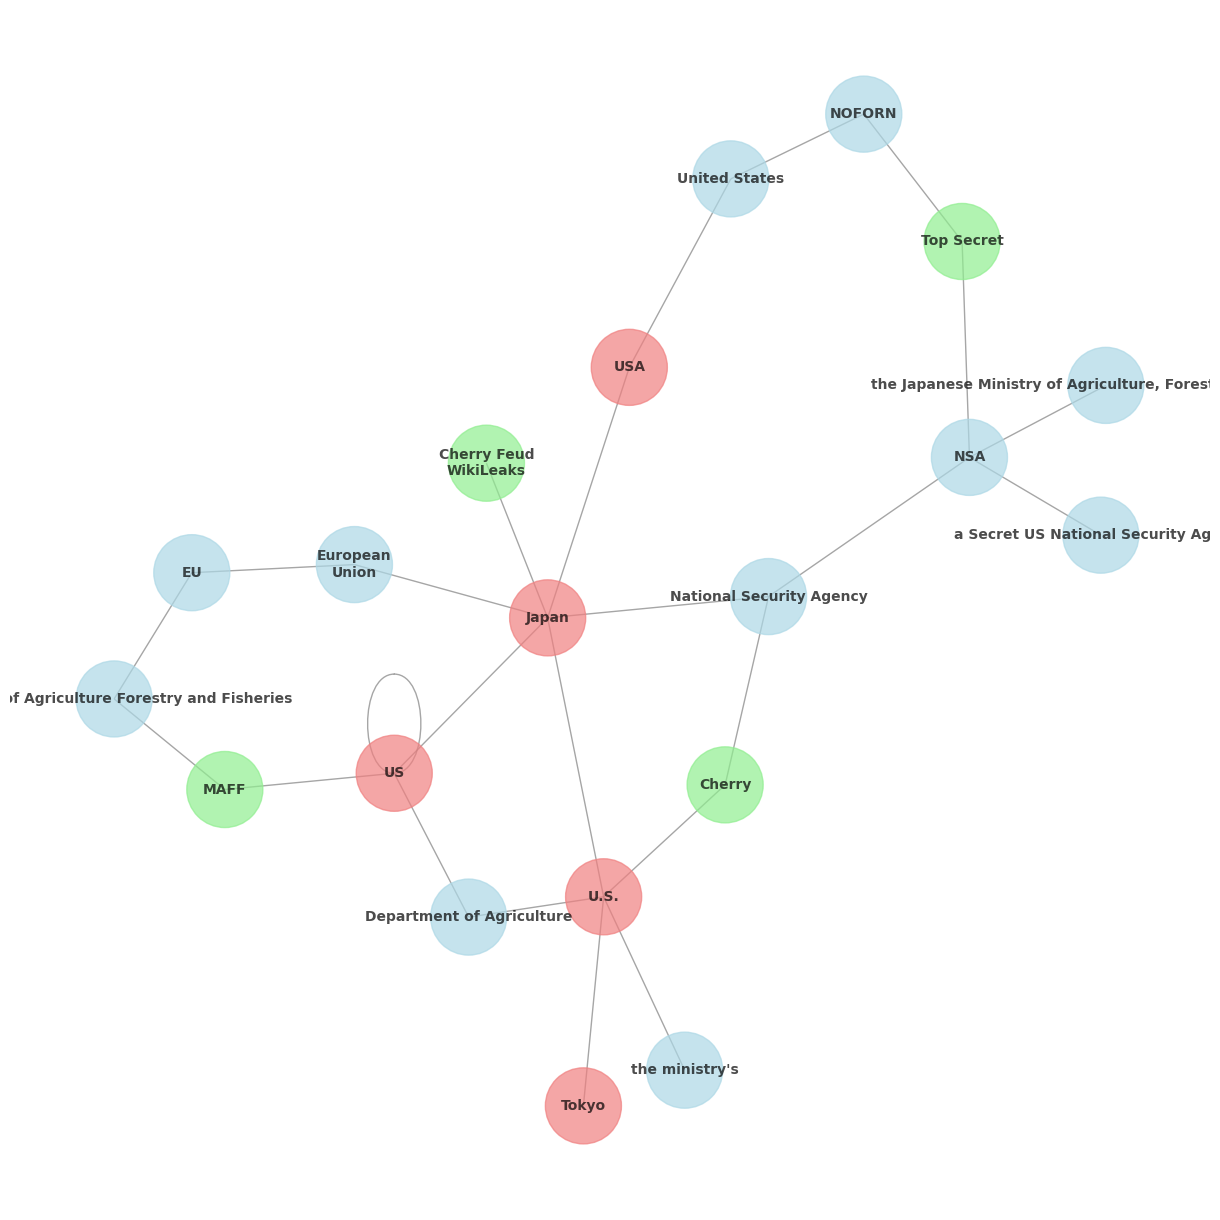

Graph for '108.pdf' saved as 'analysis_results/108.pdf_graph.png'


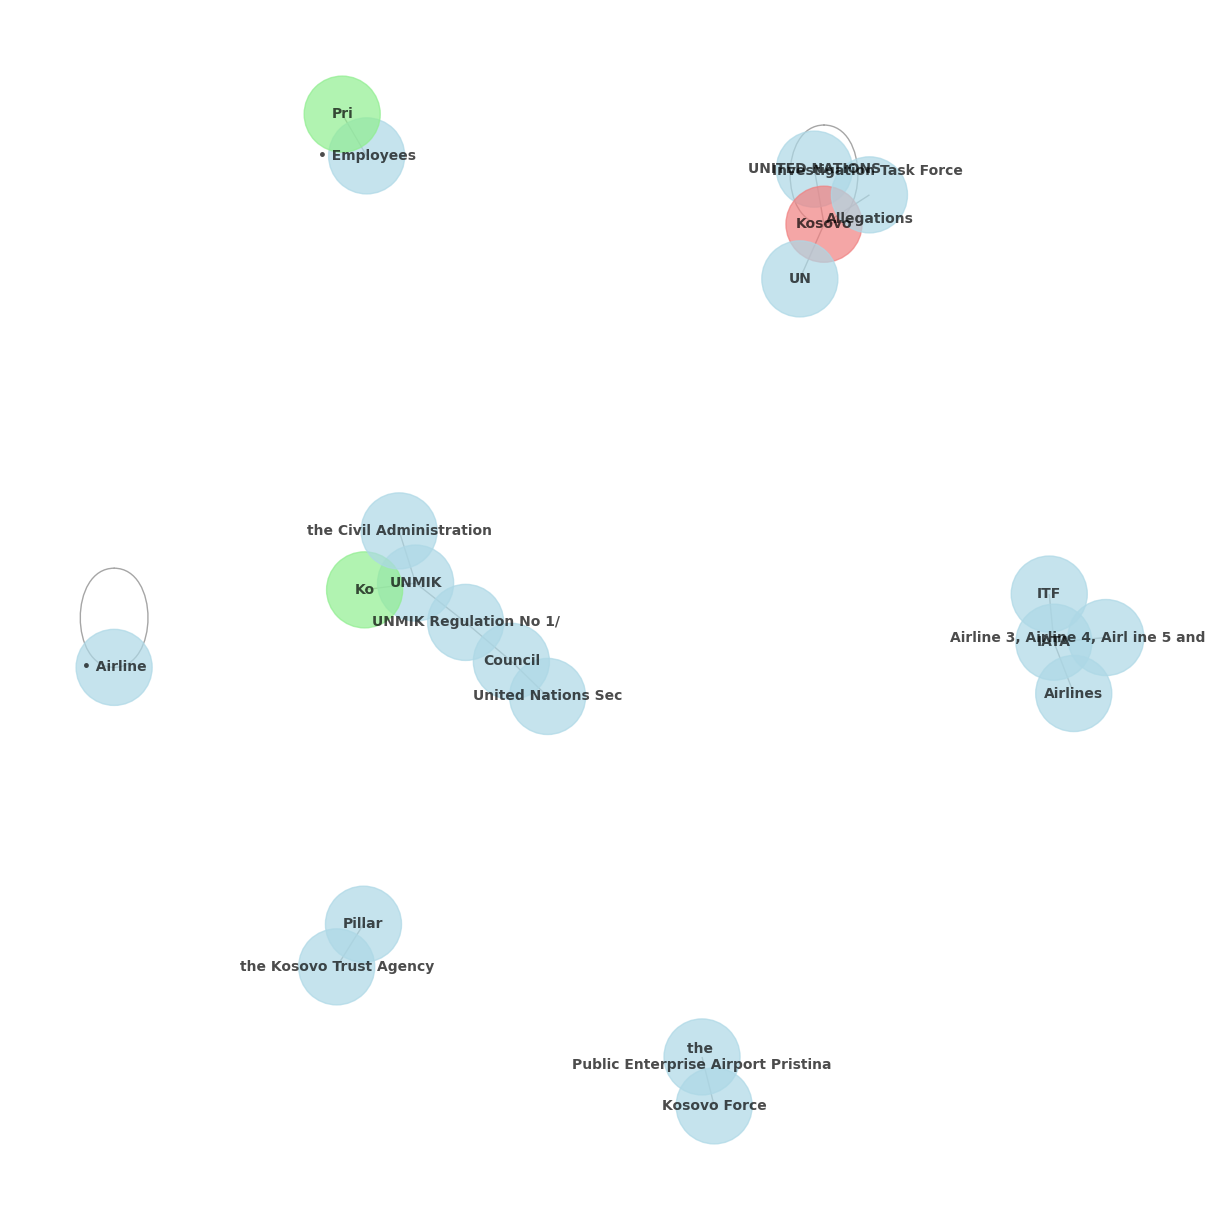

Graph for '31.pdf' saved as 'analysis_results/31.pdf_graph.png'


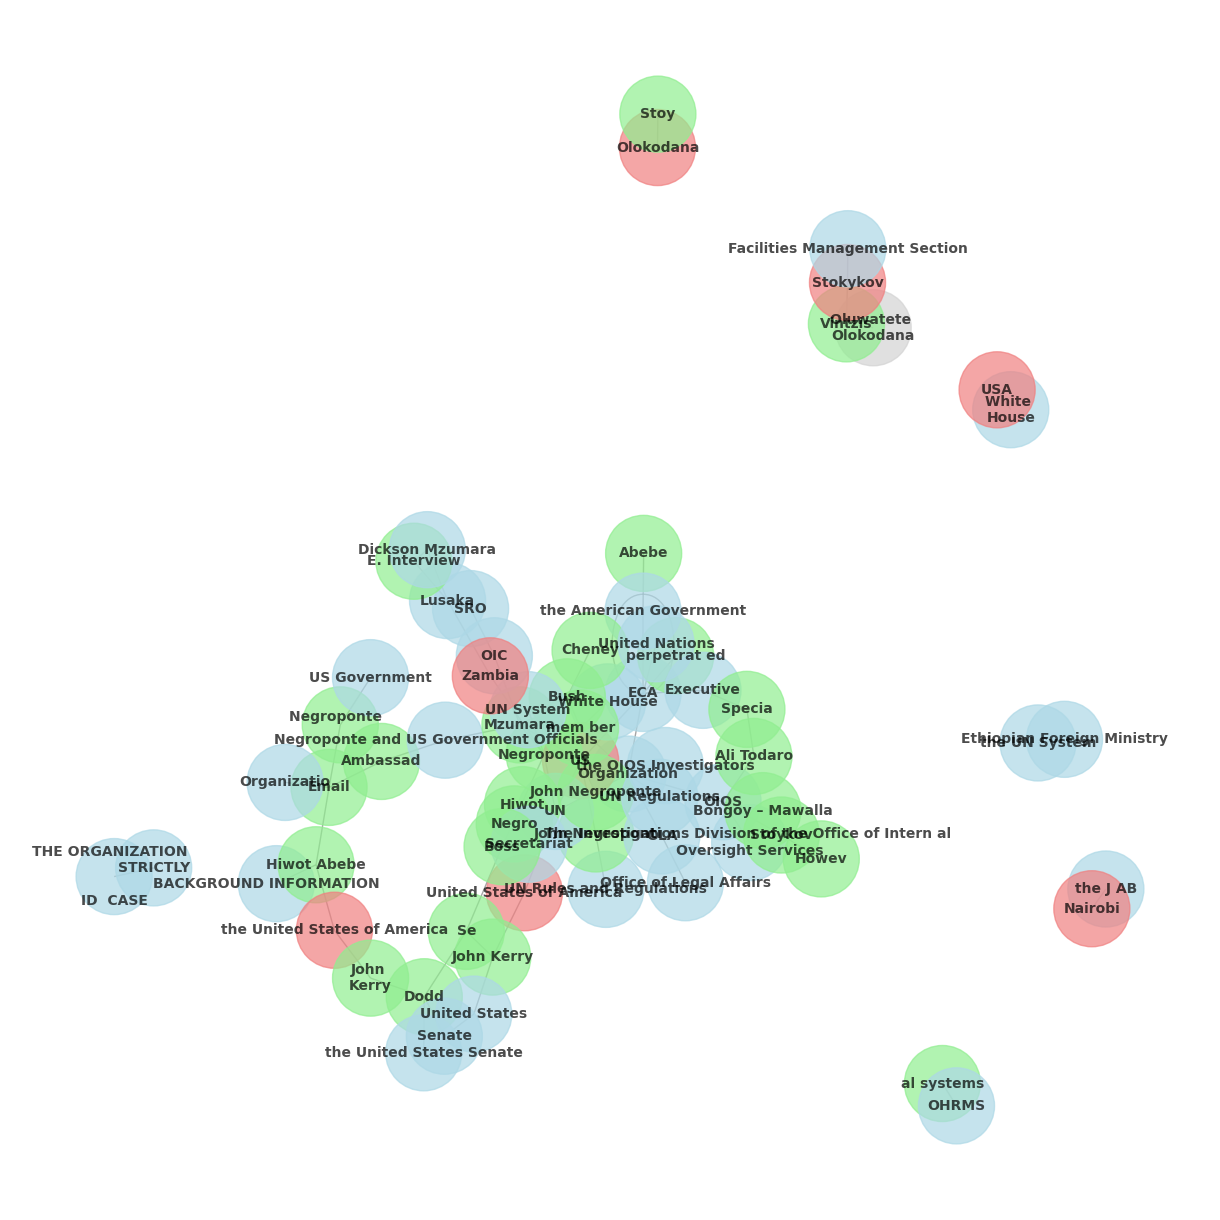

Graph for '24.pdf' saved as 'analysis_results/24.pdf_graph.png'


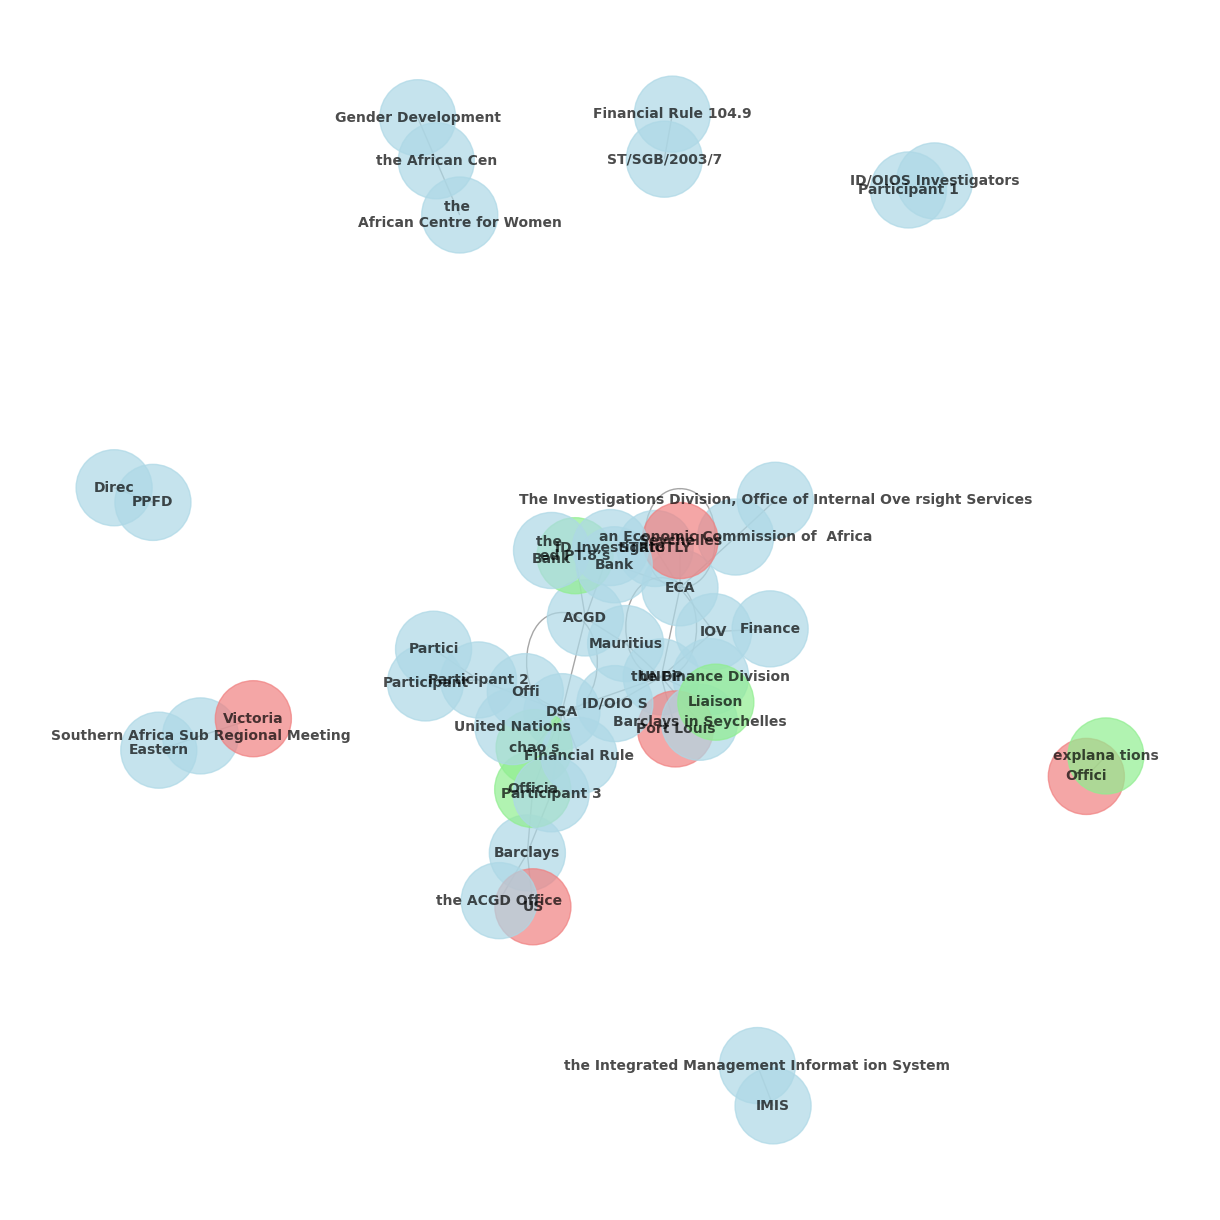

Graph for '26.pdf' saved as 'analysis_results/26.pdf_graph.png'


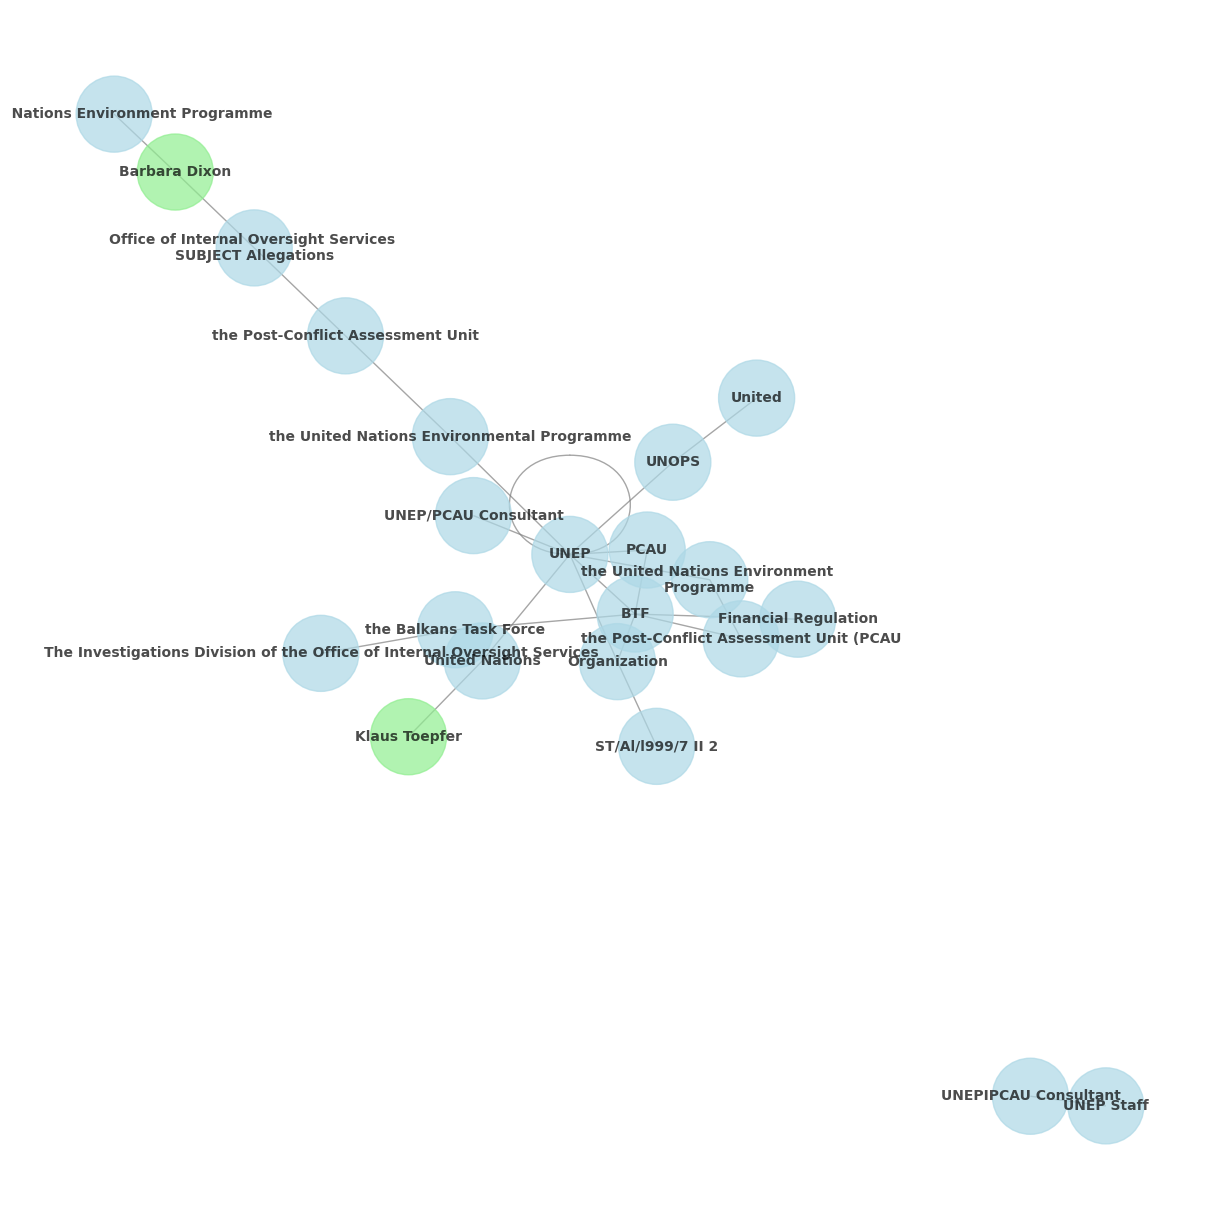

Graph for '27.pdf' saved as 'analysis_results/27.pdf_graph.png'


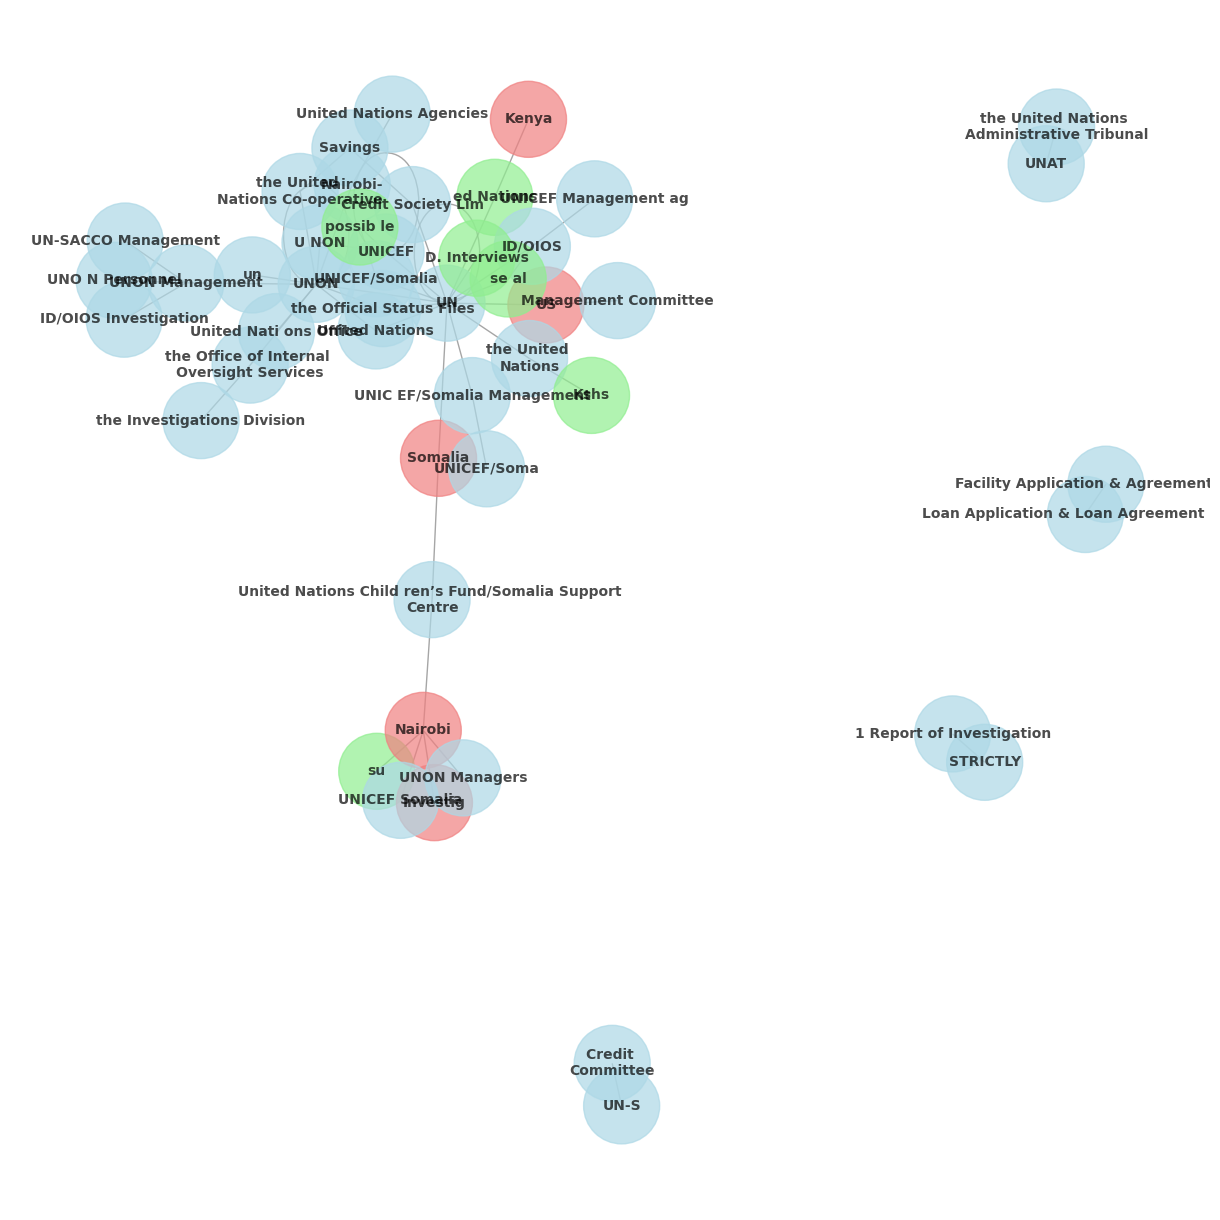

Graph for '69.pdf' saved as 'analysis_results/69.pdf_graph.png'


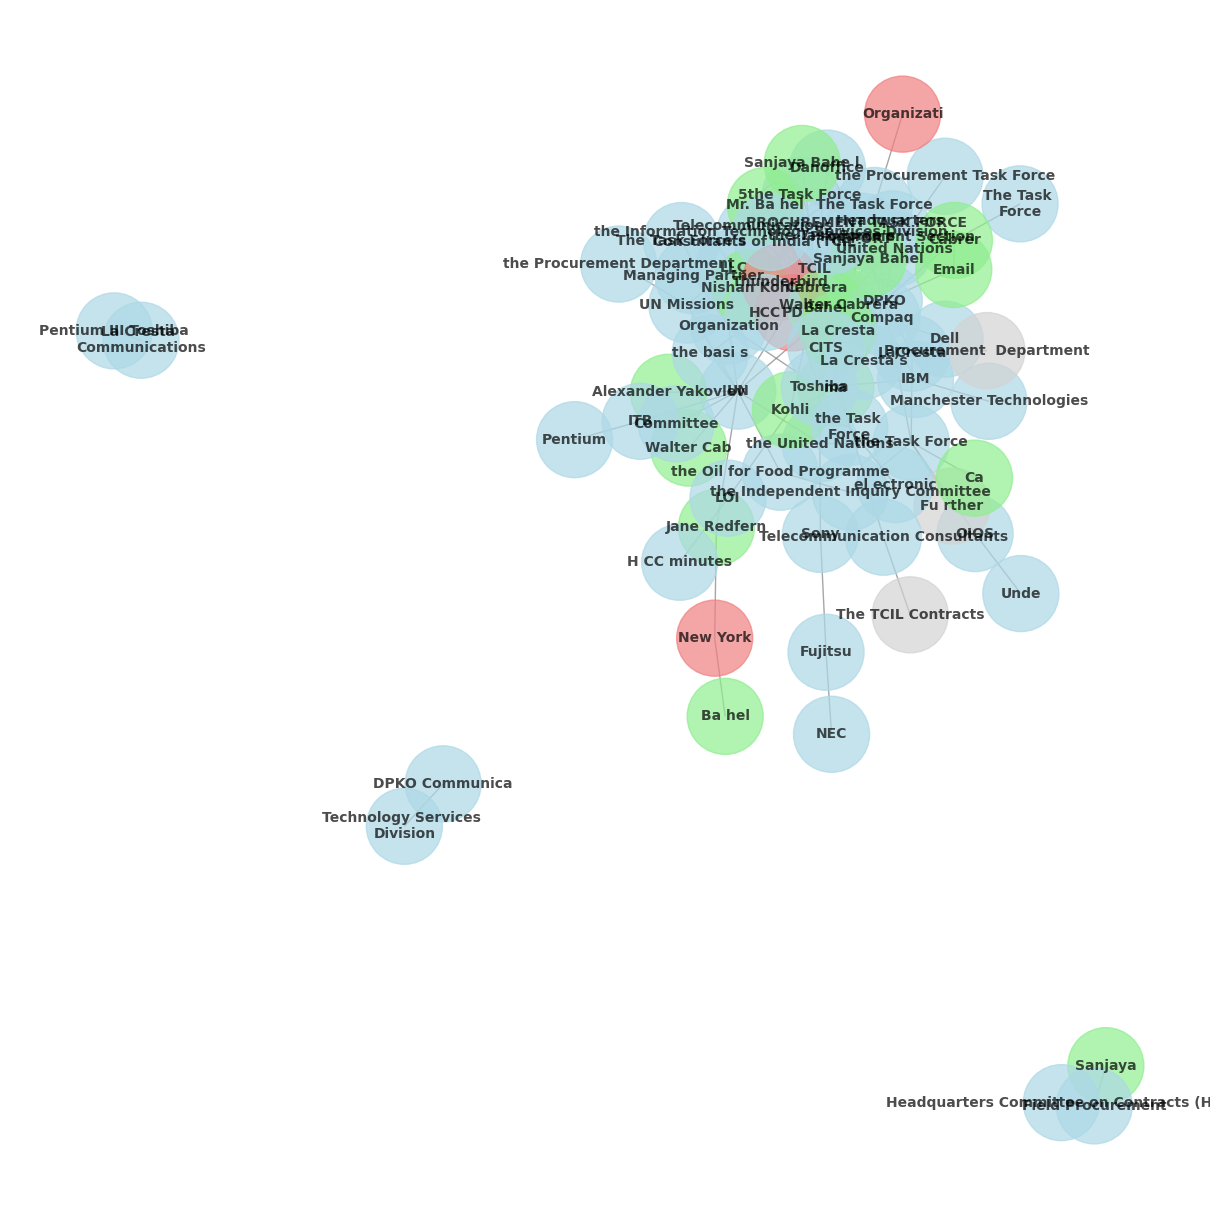

Graph for '82.pdf' saved as 'analysis_results/82.pdf_graph.png'


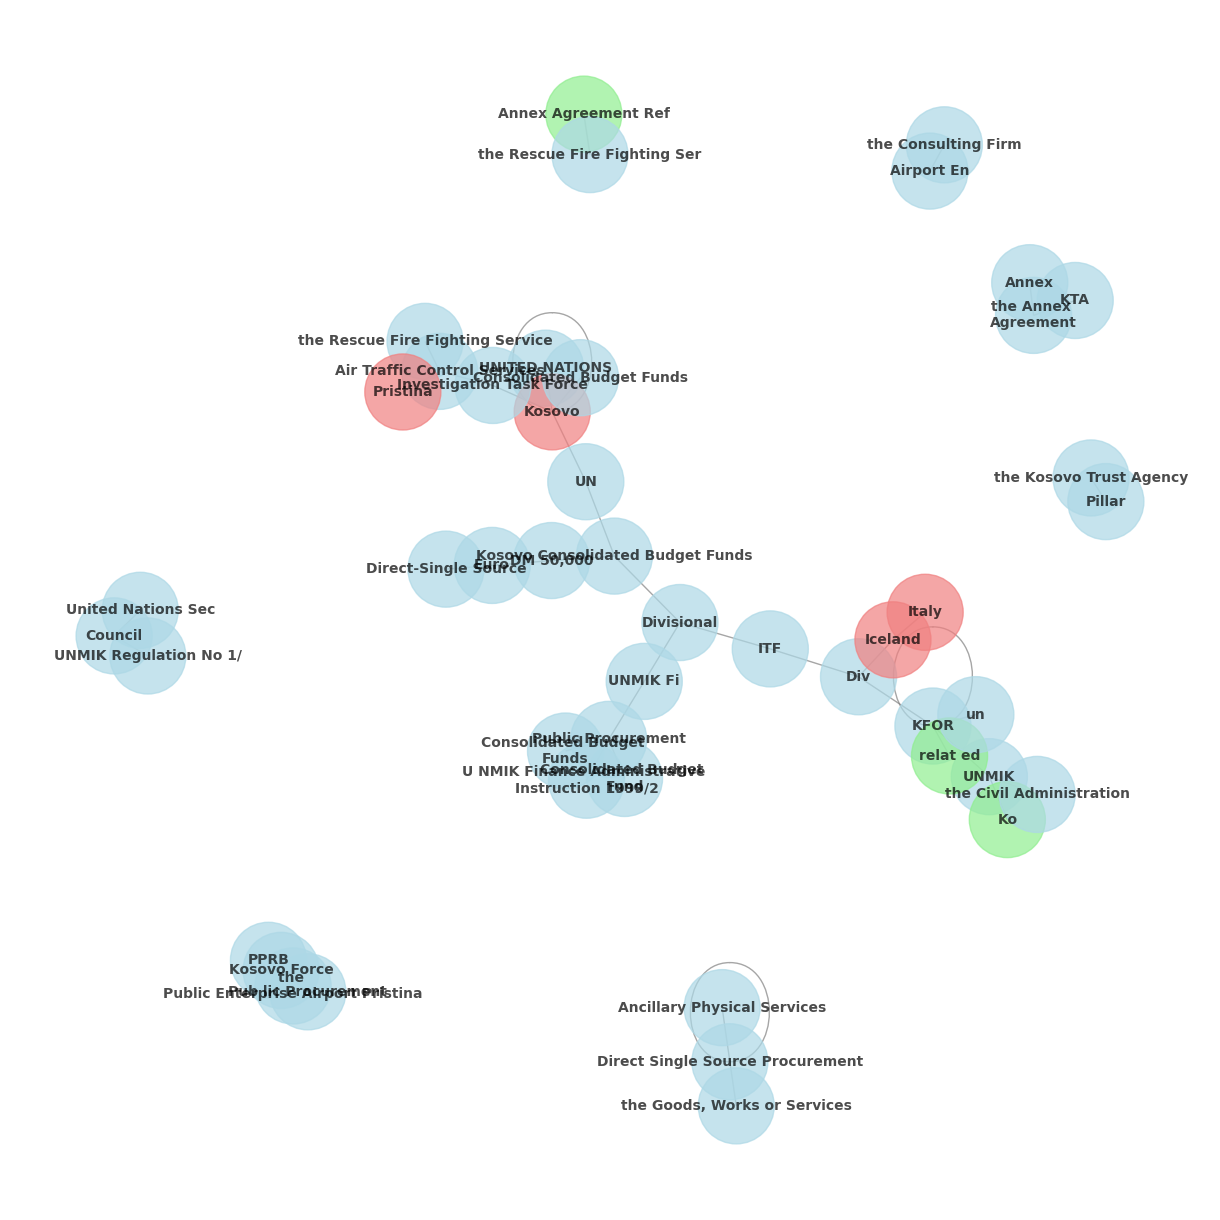

Graph for '5.pdf' saved as 'analysis_results/5.pdf_graph.png'


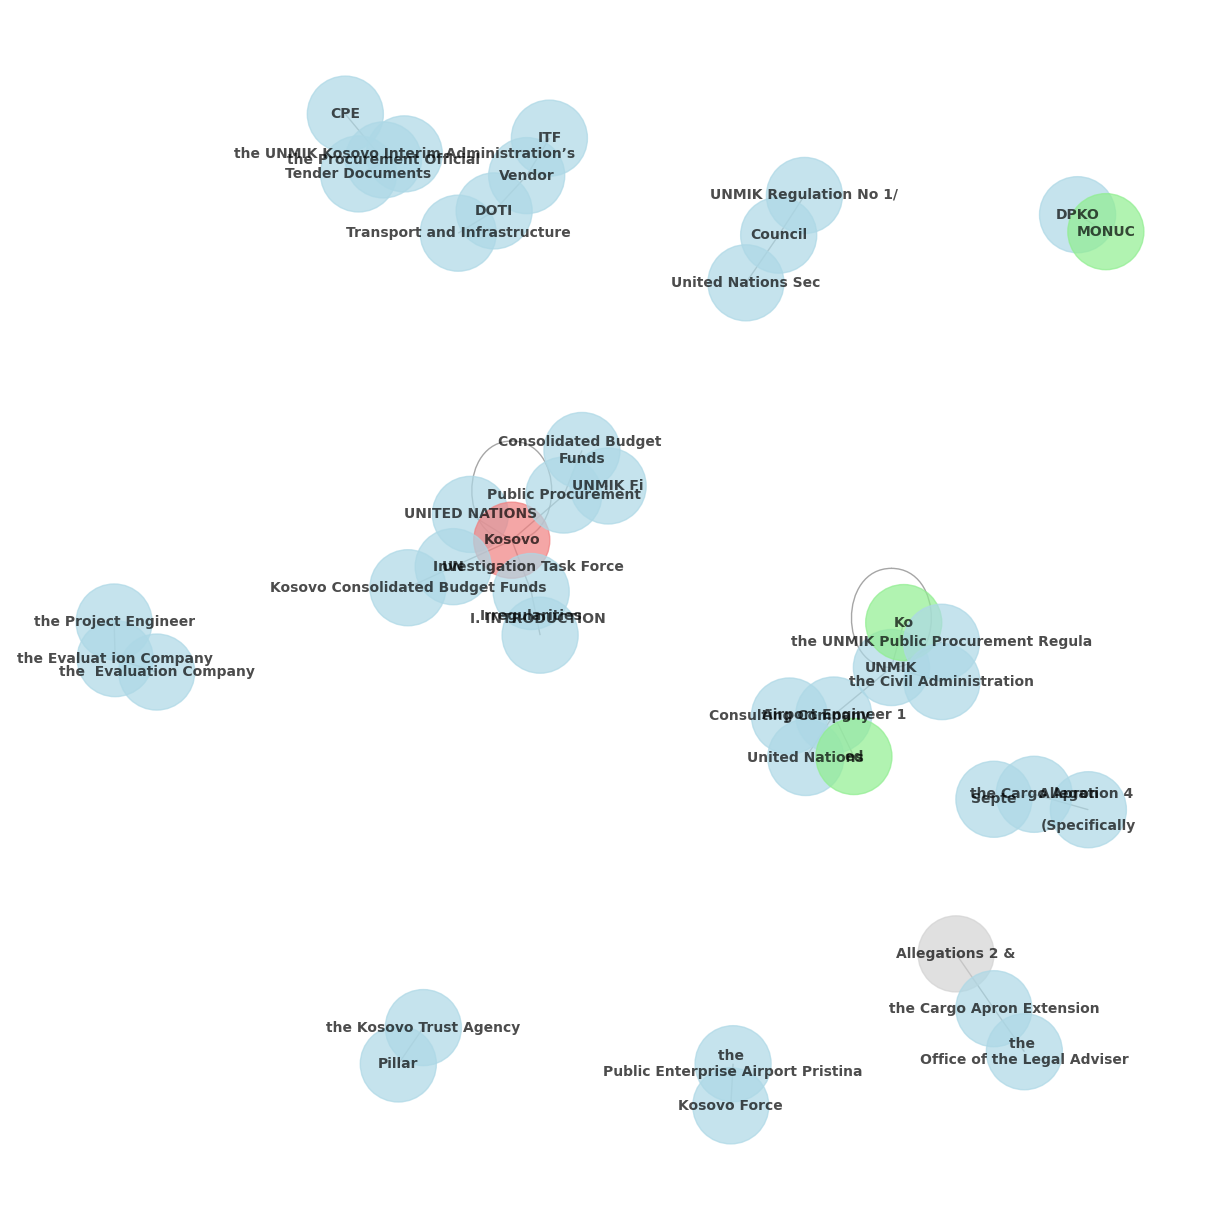

Graph for '43.pdf' saved as 'analysis_results/43.pdf_graph.png'


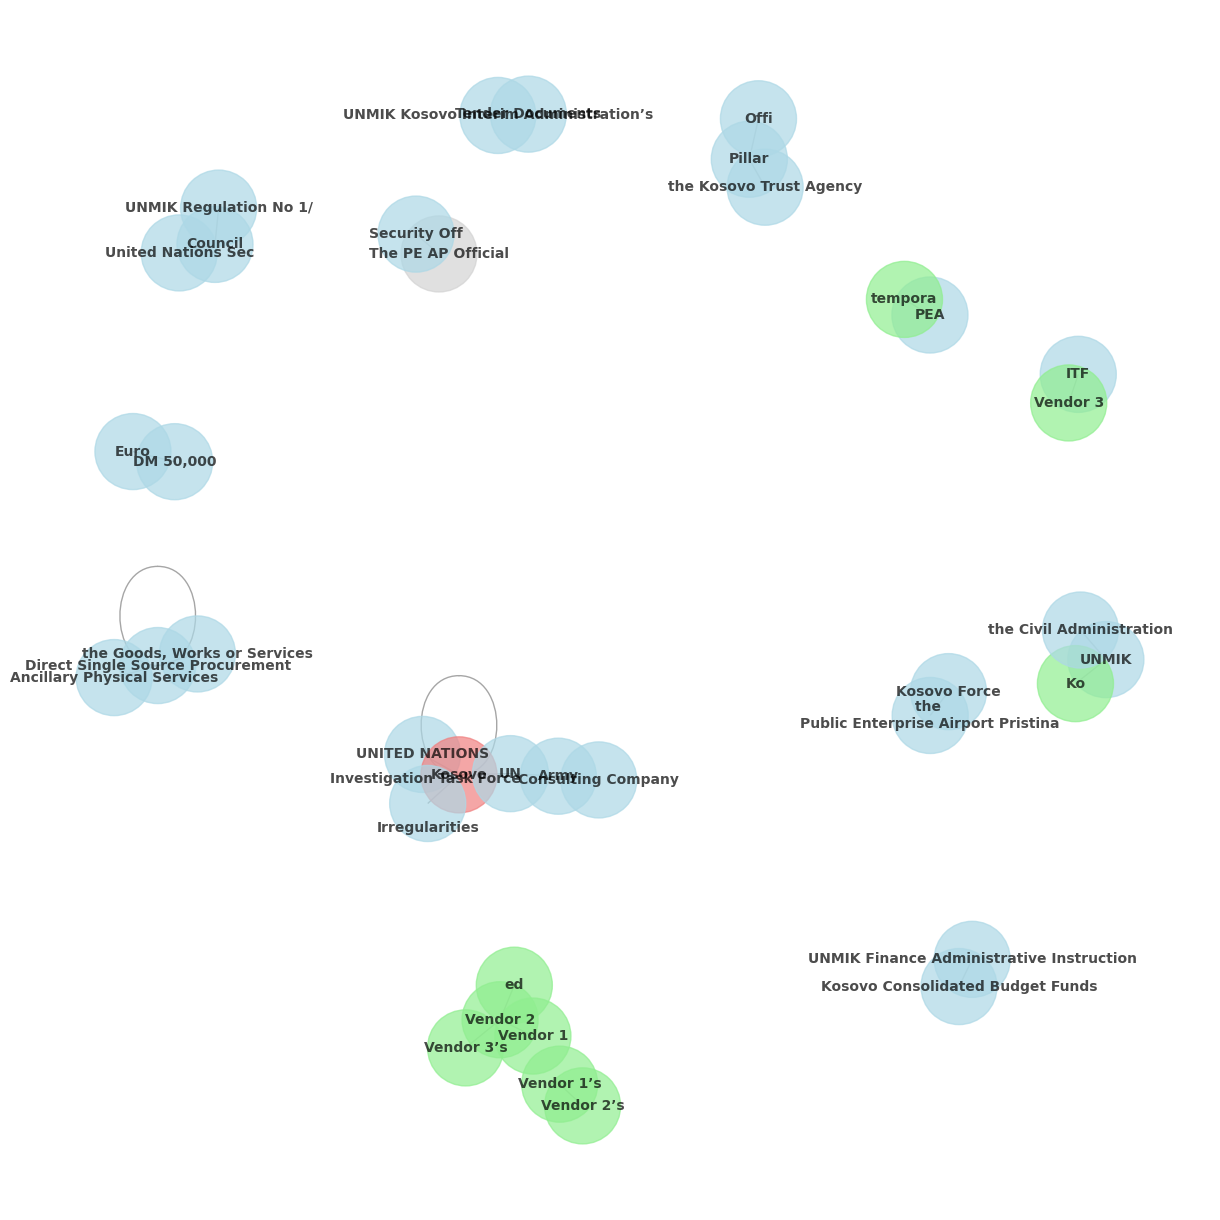

Graph for '4.pdf' saved as 'analysis_results/4.pdf_graph.png'


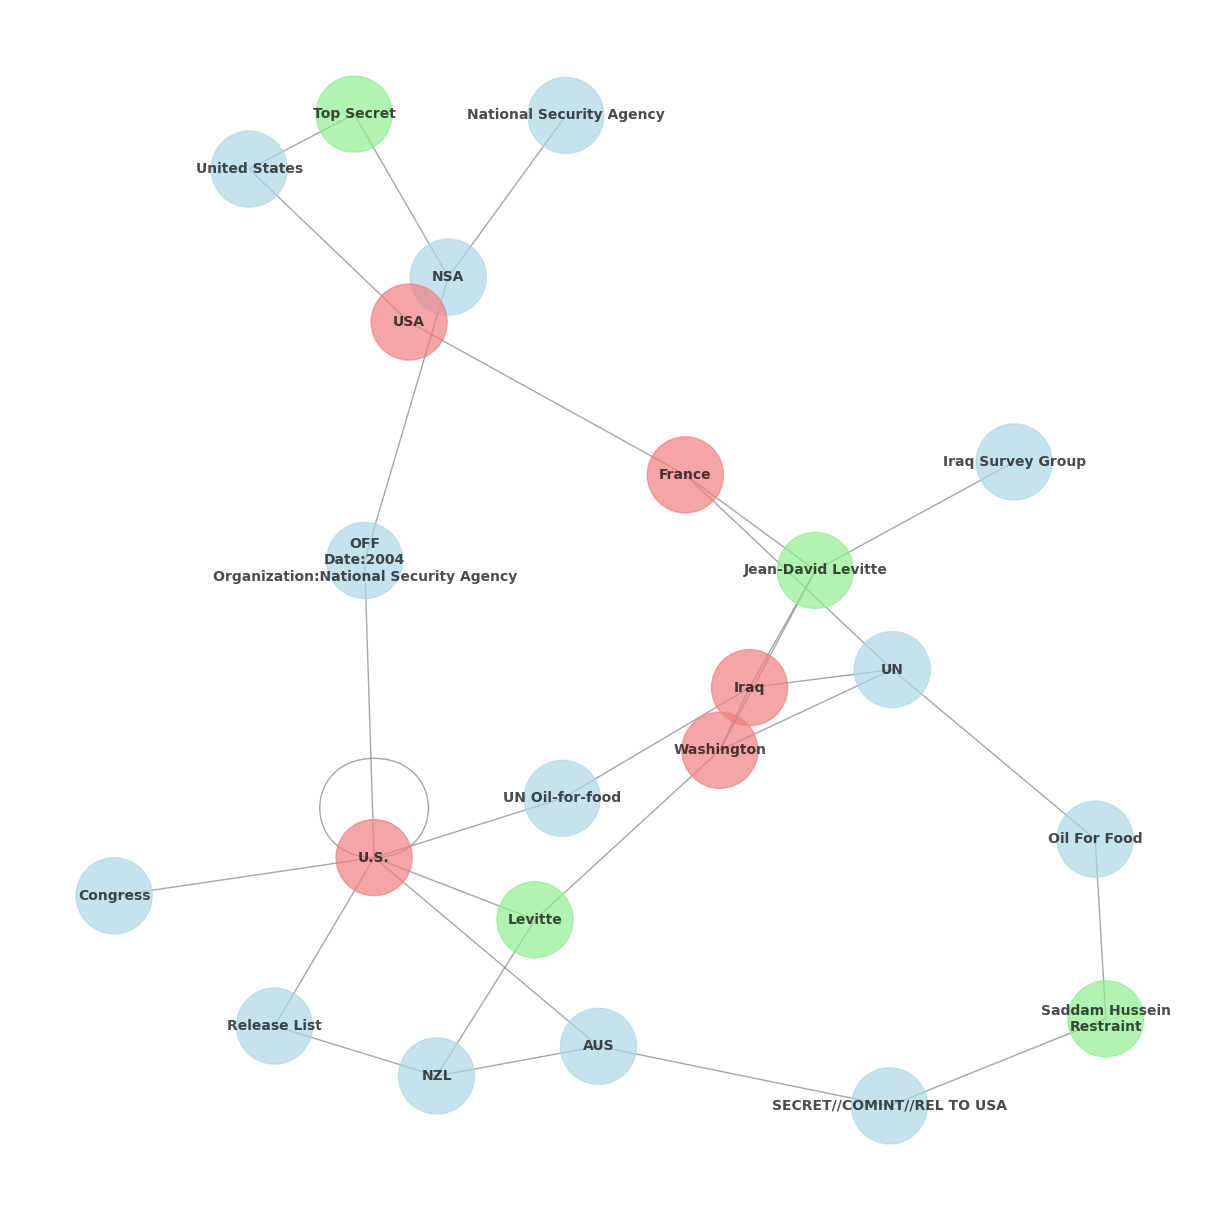

Graph for '91.pdf' saved as 'analysis_results/91.pdf_graph.png'


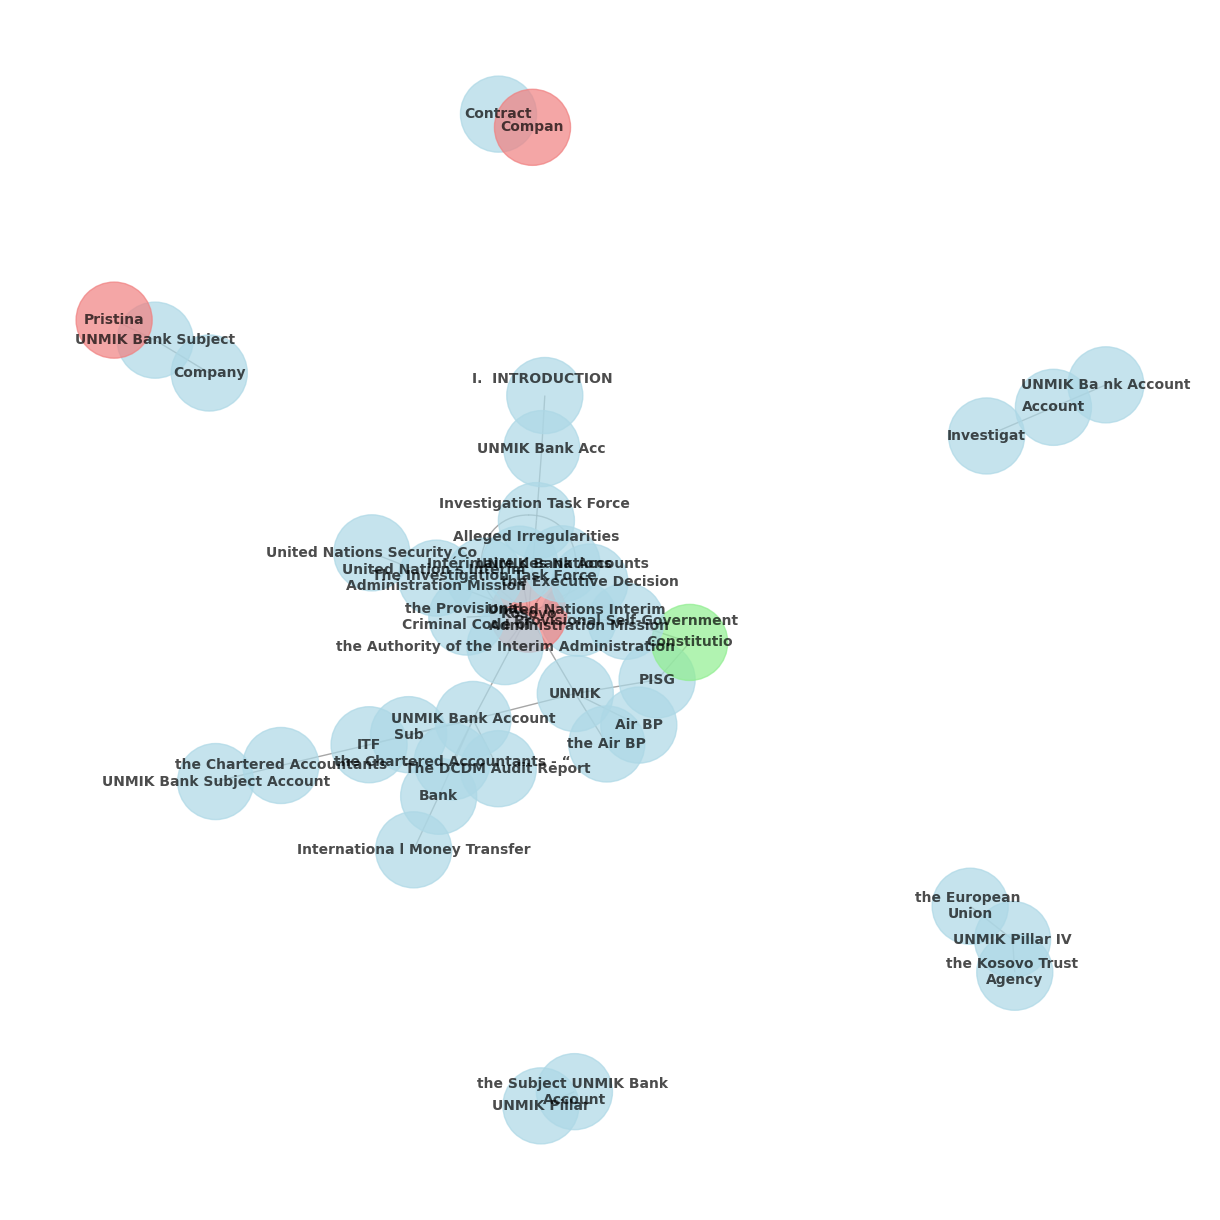

Graph for '52.pdf' saved as 'analysis_results/52.pdf_graph.png'


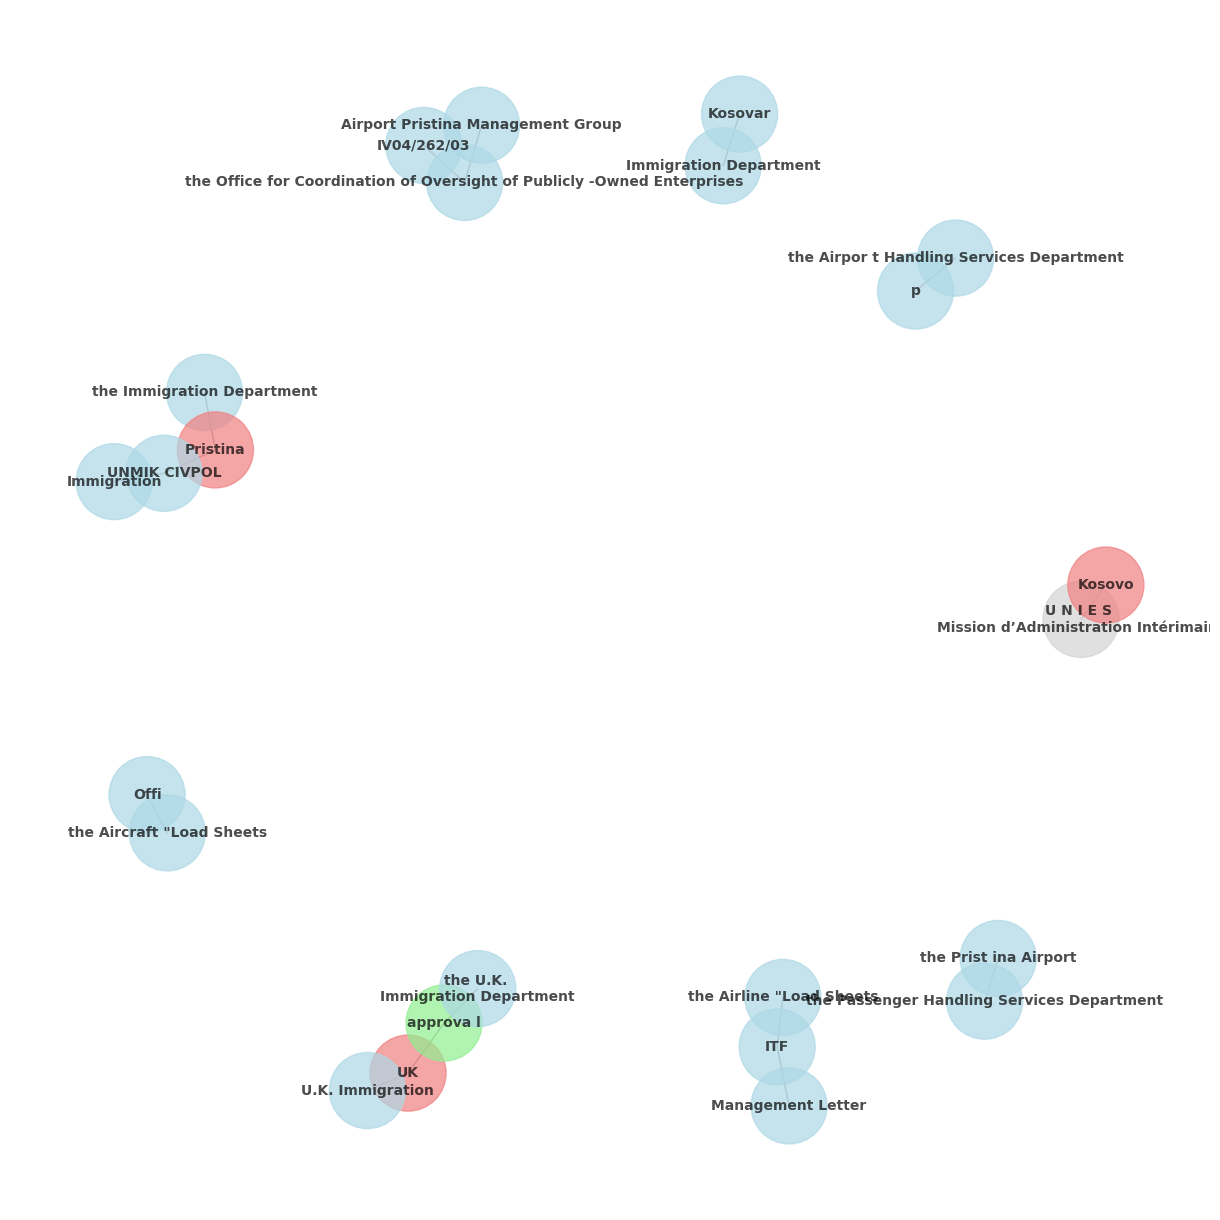

Graph for '47.pdf' saved as 'analysis_results/47.pdf_graph.png'


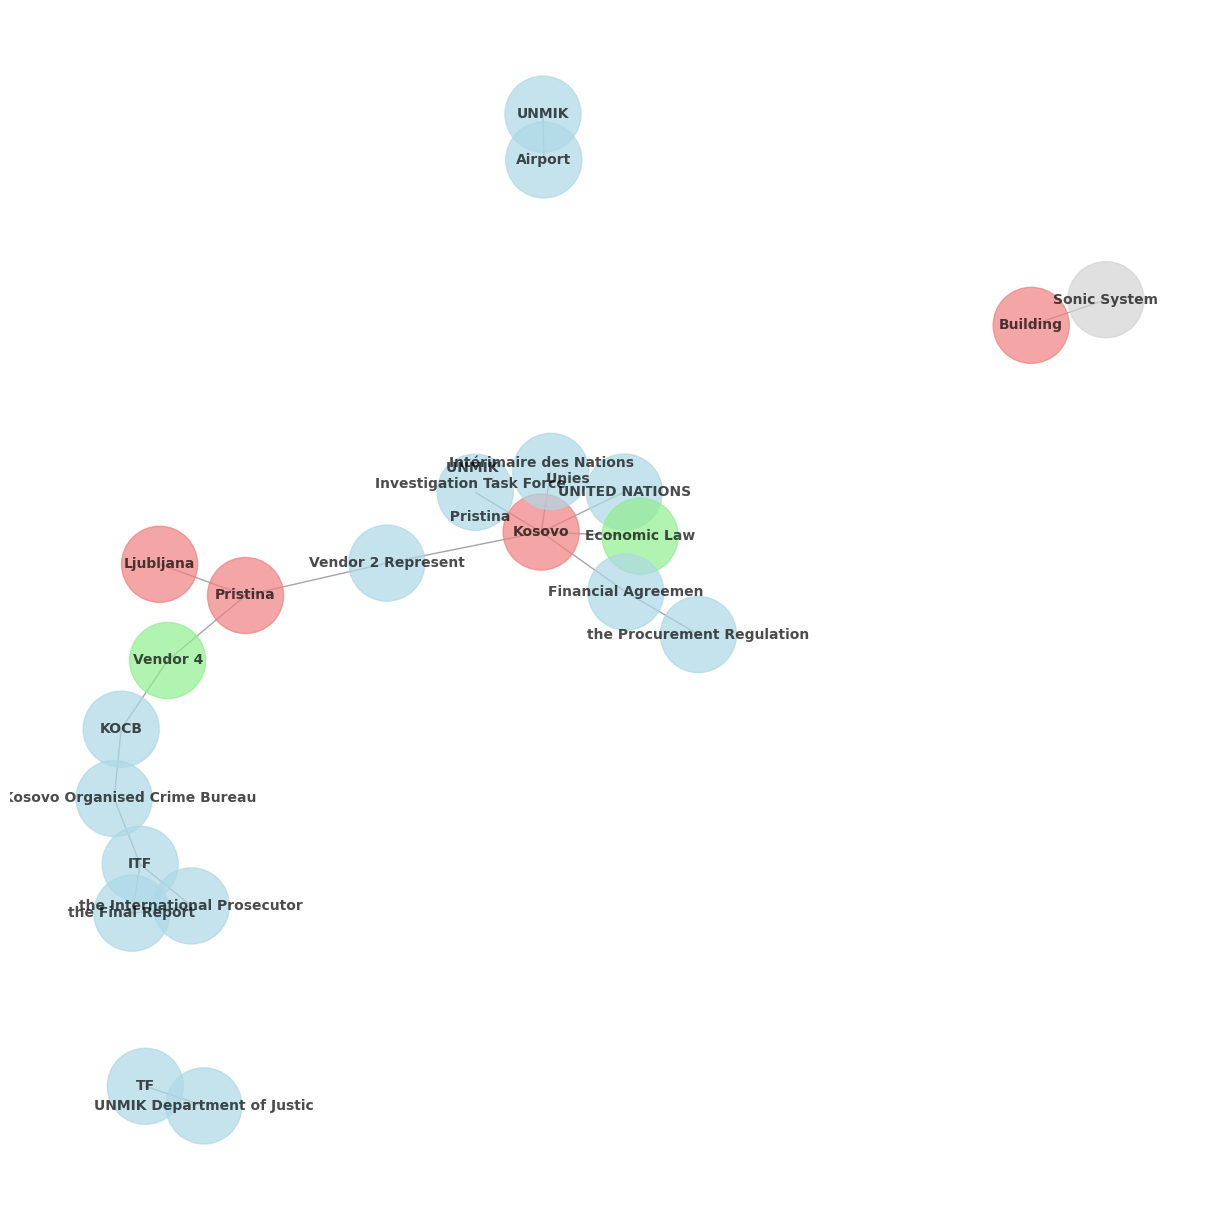

Graph for '1.pdf' saved as 'analysis_results/1.pdf_graph.png'


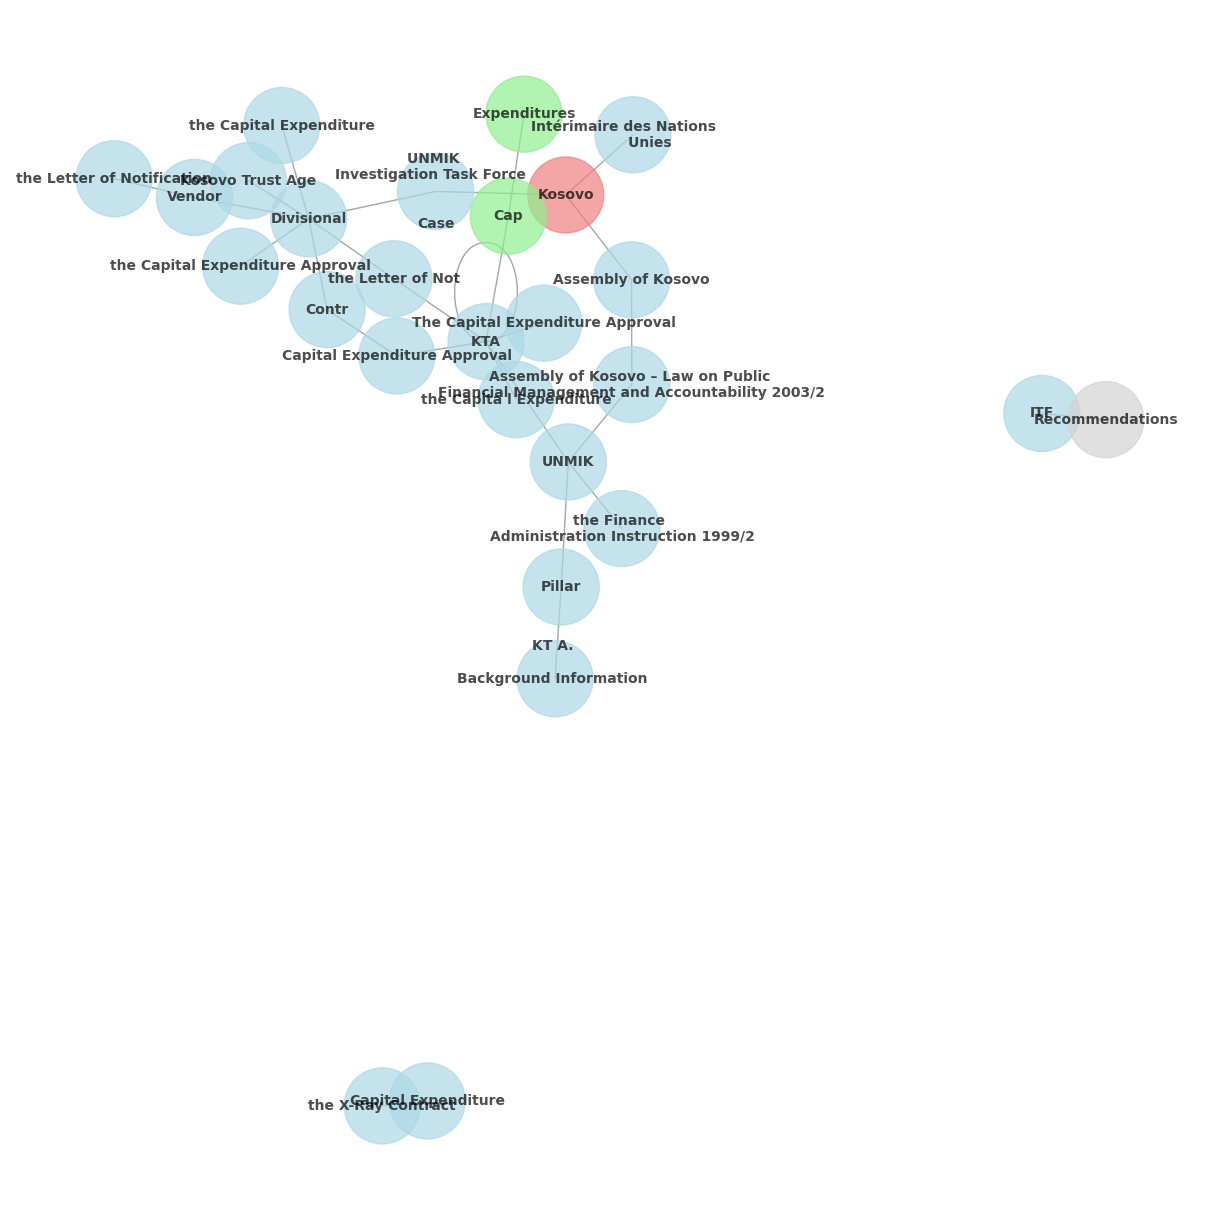

Graph for '45.pdf' saved as 'analysis_results/45.pdf_graph.png'


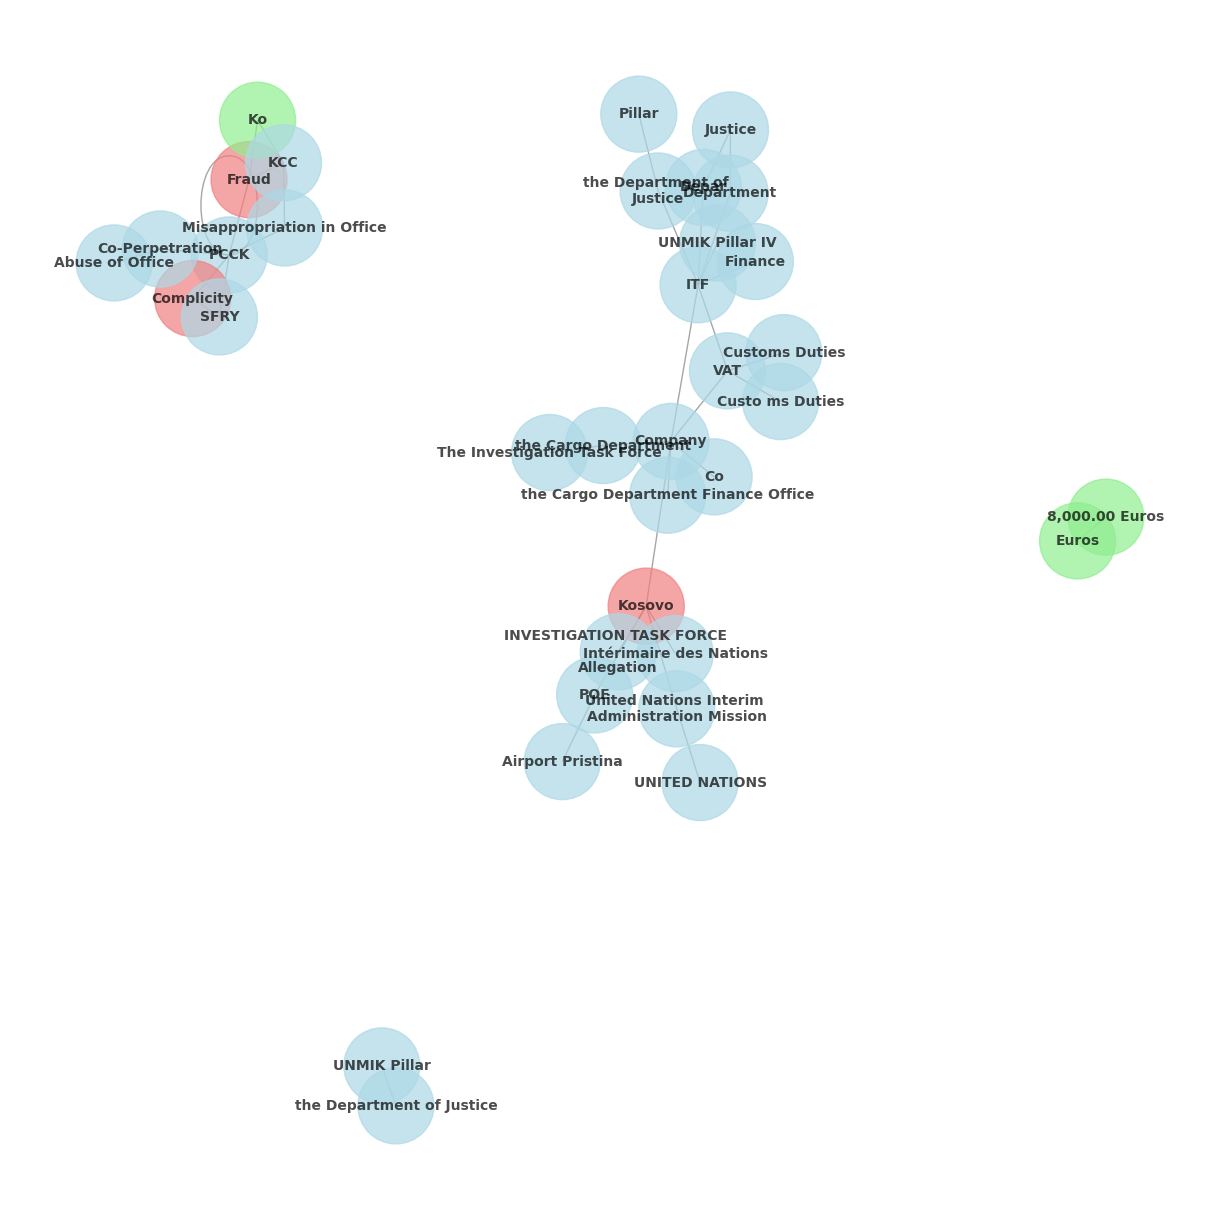

Graph for '51.pdf' saved as 'analysis_results/51.pdf_graph.png'


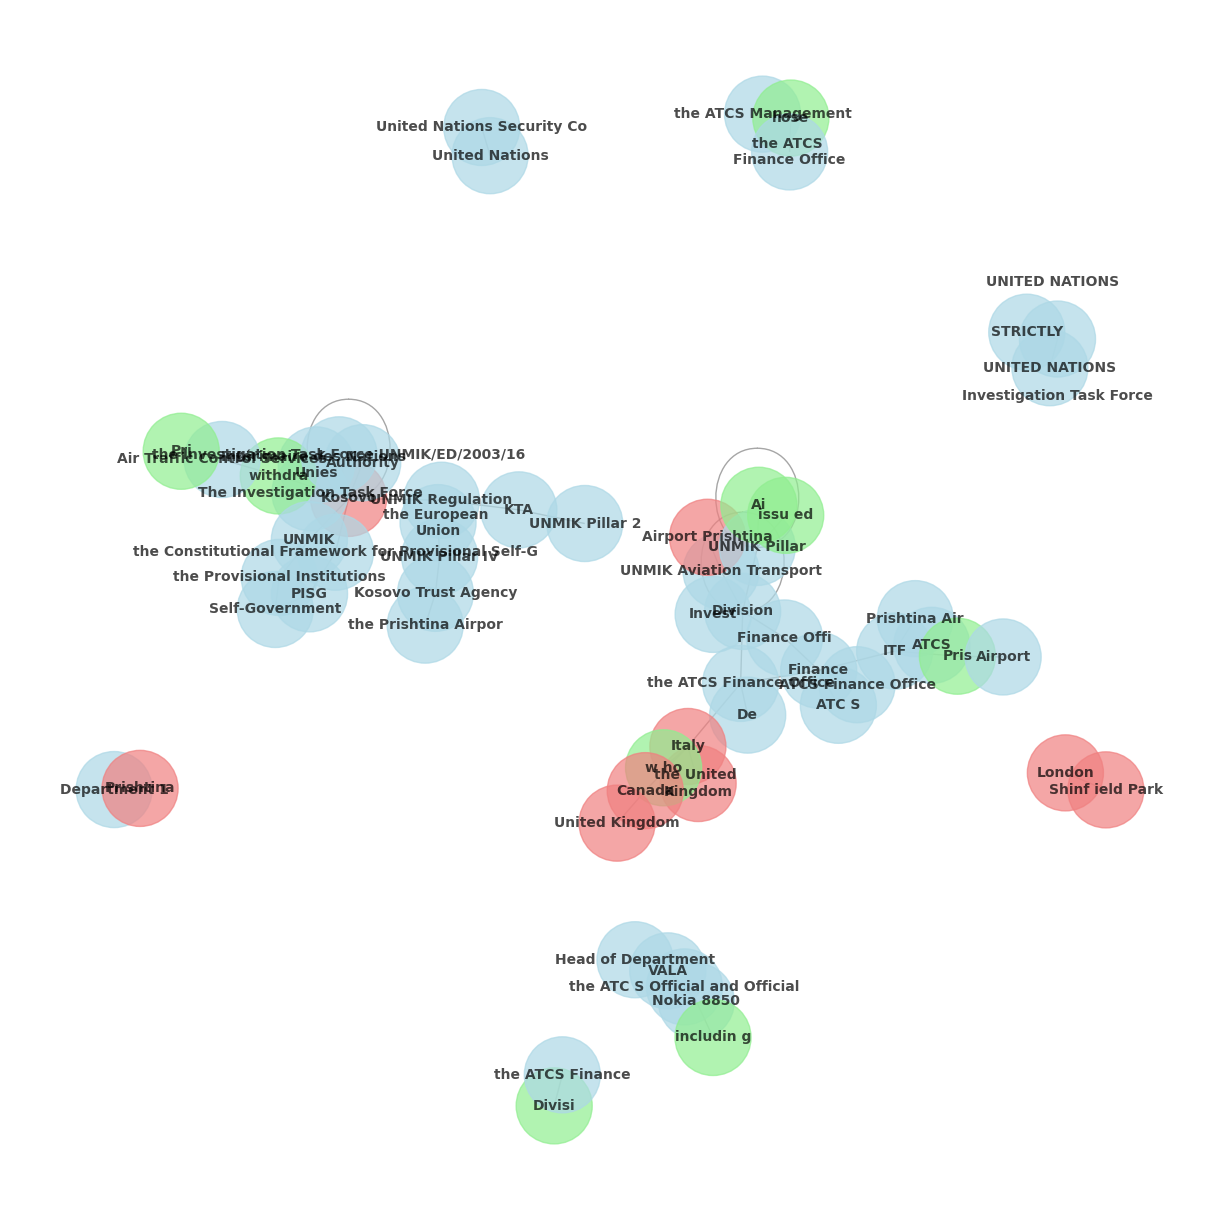

Graph for '2.pdf' saved as 'analysis_results/2.pdf_graph.png'


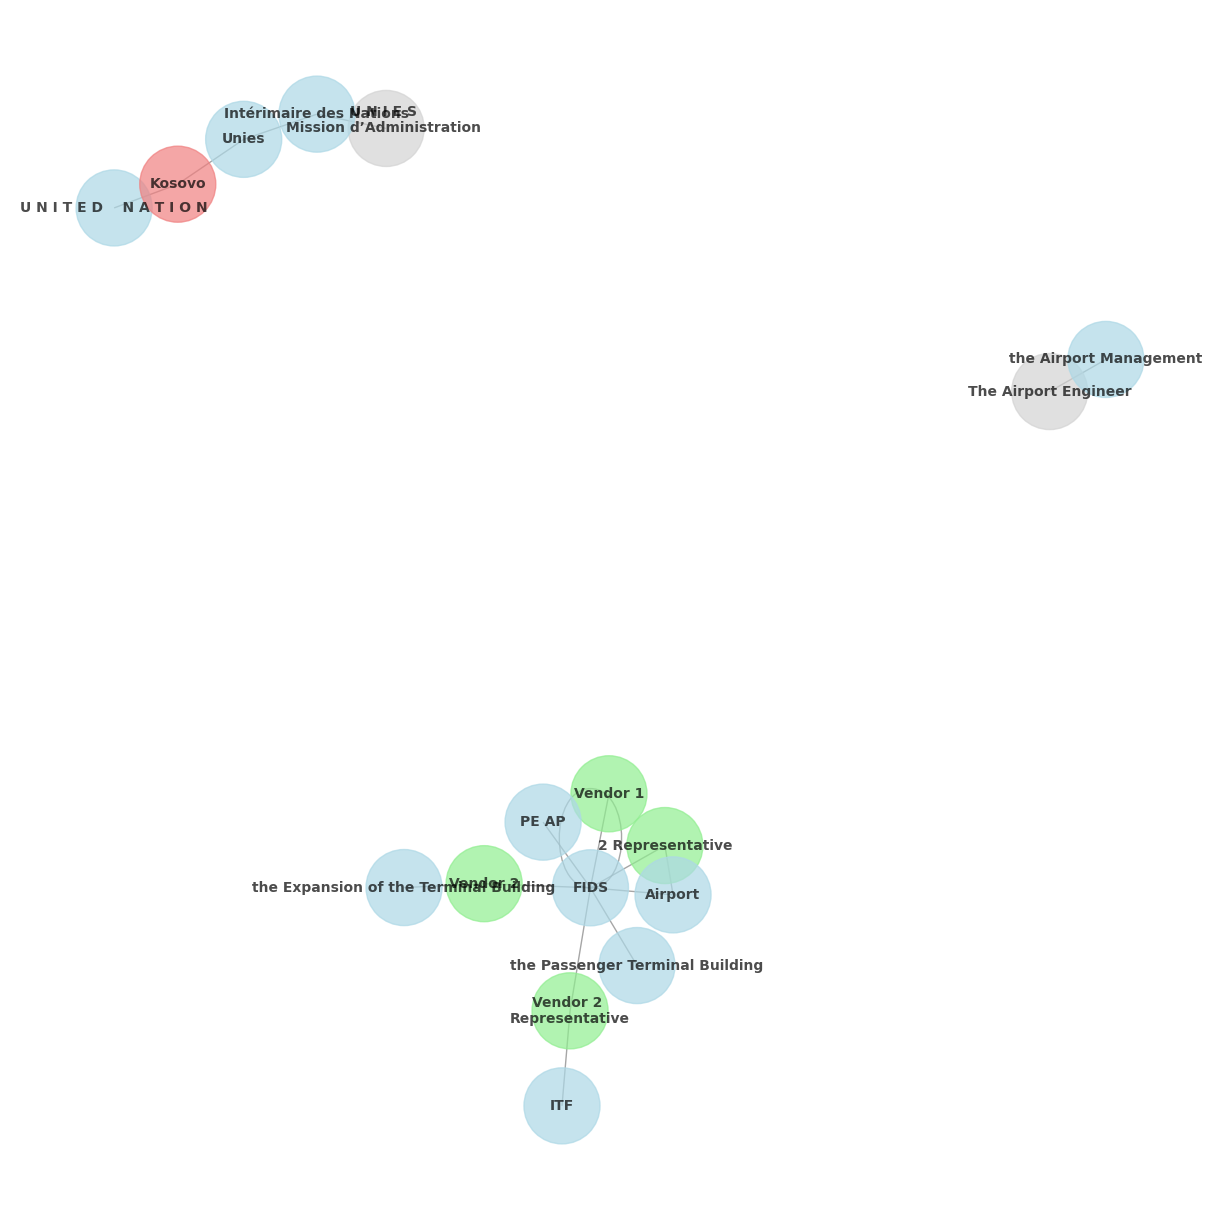

Graph for '44.pdf' saved as 'analysis_results/44.pdf_graph.png'
Results saved to 'analysis_results' directory


In [50]:
# Initialize the analyzer
analyzer = PDFTextAnalyzer()

# Process all PDFs in the directory
pdf_directory = "/Users/benitaleonardi/Downloads/Datathon pdfs"
analyzer.process_directory(pdf_directory)

# Create and visualize document-specific graphs
document_graphs = analyzer.create_document_specific_graphs()

# Save the results (CSV files)
analyzer.save_results("analysis_results")
print("Results saved to 'analysis_results' directory")

# Note: Graphs are saved automatically as PNG files in the 'analysis_results' directory.

